<h1><center>Vietnam Stock Market - Quantitative Trading Analysis</center></h1>
<h3><i>Content:</i></h3>
<h3>1. Problem statement</h3>
  <li>What is momentum, mean reversion & seasionality</li>
  <li>Why & How you find it</li>
<h3>2. Data wrangling & EDA</h3>
  <li>Historgram</li>
  <li>Bolinger band, high-low band (breakout)</li>
  <li>View time series/cross sectional for pattern recognition</li>
  <li>Hypothesis refinement</li>
<h3>3. Model construction</h3>
  <p>Candidate selection</p>
  <p>Quantopian zipline & alphalens</p>
  <p>3.1. Risk model</p>
  <p>3.2. Alpha model</p>
  <p>3.3. Multi factor model</p>
<h3>4. Conclusions & Recommendations</h3>

<h2>1. Problem statement</h2>  
<b>Investors will continue to suffer behavioral bias</b>
<p>Vietnam stock exchange is one of the most potential raising up players among frontier markets. The market is in the developing stage and lacking massive & advanced financial tools such as quantitative analysis, an alternative of fundamental & conventional technical ones. Quantitative analysis (a heuristic work) computes statistics called indicators, that can combine many indicators, look for contrast and trade in all range of trading frequency (seconds, minutes, day... years).<br>
The project goal is using 10 years historic stock data analyzing betas & three prevailing alpha factors: Momentum, Mean reversion & Seasonality to optimize weights by neutralizing market risks & preserving alphas, hence maximize portfolio returns. It is expected as an initial glance to domestic investors on how the massive trading algorithm in the mature/developed market which is applicable in frontier ones.</p>

<b>What is momentum?</b>  
<p><a href=https://www.investopedia.com/terms/m/momentum.asp>Momentum</a> is the rate of acceleration of a security's price—that is, the speed at which the price is changing. Momentum trading is a strategy that seeks to capitalize on momentum to enter a trend as it is picking up steam.The goal is to work with volatility by finding buying opportunities in short-term uptrends and then sell when the securities start to lose momentum.</p>  
<b>What is mean reversion?</b><br>
<p><a href=https://blog.quantinsti.com/mean-reversion-strategies-introduction-building-blocks/>Mean reversion theory</a> states that security prices and economic indicators such as interest rates will tend to revert to the historical mean prices</p>
<b>What is seasonality?</b><br> 
<p>People believe that stocks have significantly higher returns during the night session compared to the daily session - close to open (CTO)</p>
<b>Why are momentum, mean reversion & seasonality?</b>  
<p>Random walk theory suggests that changes in stock prices have the same distribution and are independent of each other. Stock prices are non-stationary (mean, variance, covariance is changed over time) then it is unlikely able to using the past price to predict the future one. Price is not comparable by time & among stocks</p>
<p> Many of the rationales presented for the strategy’s success fall into one of two behavioral categories: Investors either overreact to important information, or they underreact to it, that leads to momentum effect. Because, after all, we’re only human. (<a href=https://anderson-review.ucla.edu/momentum/>Subrahmanyam</a>) </p>
<p>Finding & modeling patterns (factors) from returns which is more stationary & comparable is the major trend, momentum is one of the most resilent factors</p>
<b>How to find momentum patterns</b>  
<p>Momentum, finance, refers to the capacity for a price trend to sustain itself going forward.</p>
<p>Strong momentum can continue in an upward or downward trend, which can be confirmed by changes in trading volume and other technical indicators.</p>
<p>Momentum investing is a trading strategy in which investors buy securities that are rising and sell them when they look to have peaked.</p>
<p>Momentum trading therefore describes a herding strategy, following others; but price trends are never guaranteed in the future.</p>

<b>To accomplish these tasks, the following steps need to be accomplished: Hypothesis statement; Data wrangling & EDA; Model construction; Factors assesment: Weights optimization.</b>  
<b>The data are collected from : </b><a href=https://www.vndirect.com.vn/portal/thong-ke-thi-truong-chung-khoan/lich-su-gia.shtml>vndirect</a>
& <a href=https://s.cafef.vn/Lich-su-giao-dich-VNINDEX-1.chn#data>cafef</a>

In [15]:
import sys
print(sys.executable)

e:\temp\AI4Trading\Project4\Python36\python.exe


In [18]:
!{sys.executable} -m pip install graphviz

You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Load Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cvxpy as cvx
import zipline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime

import functions  
import risk_model_funcs as rmf
import alpha_model_funcs as amf
import multi_factor_funcs as mff
import visualizations
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 120

<h2>2.  Data wrangling & EDA</h2>  

### Load Data
The data we use for most of the projects is end of day data. This contains data for 621 stocks, but we'll be looking at stocks in the VN100. We also made things a little easier to run by narrowing down our range of time period instead of using all of the data.

In [2]:
engine = sqlalchemy.create_engine('sqlite:///' + 'vn650')
pd.read_sql('FPT', engine).head(2)
# pd.read_sql('select * from FPT', engine)

date       open       high        low      close  volume  unadjusted  \
0  2006-12-13  19.225752  19.225752  19.225752  19.225752   83530       400.0   
1  2006-12-14  20.187039  20.187039  20.187039  20.187039  280710       420.0   

   putthrough ticker  year  quarter  dividend  
0           0    FPT  2006        4       NaN  
1           0    FPT  2006        4       NaN

In [3]:
tickers = np.array(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'",engine)).flatten()

In [4]:
dfs = [pd.read_sql(ticker, engine) for ticker in tickers]

In [5]:
df = pd.concat(dfs,ignore_index=False)

In [6]:
df['date'] = pd.to_datetime(df.date)

In [7]:
df = df.sort_values(by=['date'], ascending=False)

In [8]:
df = df.set_index('date')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1497337 entries, 2021-11-26 to 2006-03-13
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1497337 non-null  float64
 1   high        1497337 non-null  float64
 2   low         1497337 non-null  float64
 3   close       1497337 non-null  float64
 4   volume      1497337 non-null  int64  
 5   unadjusted  1497337 non-null  float64
 6   putthrough  1497337 non-null  int64  
 7   ticker      1497337 non-null  object 
 8   year        1497337 non-null  int64  
 9   quarter     1497337 non-null  int64  
 10  dividend    910635 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 137.1+ MB


In [9]:
df['simple_return'] = df.groupby('ticker')['close'].pct_change()
df['log_return'] = np.log(1 + df.groupby('ticker')['close'].pct_change())

In [14]:
df.tail()

open       high        low      close  volume  unadjusted  \
date                                                                         
2006-03-13   4.424317   4.588181   4.424317   4.588181    3150        28.0   
2006-03-13  11.119323  11.182862  11.119323  11.182862   73310        35.2   
2006-03-13  16.032919  16.032919  15.789996  16.032919   84320        66.0   
2006-03-13   5.179641   5.565359   5.179641   5.207192   70600        18.9   
2006-03-13   3.111419   3.111419   3.111419   3.111419   53340        40.9   

            putthrough ticker  year  quarter  dividend  simple_return  \
date                                                                    
2006-03-13           0    TS4  2006        1       NaN      -0.007092   
2006-03-13           0    TYA  2006        1       NaN       0.005714   
2006-03-13           0    GMD  2006        1       NaN      -0.014925   
2006-03-13           0    VSH  2006        1       NaN      -0.040609   
2006-03-13           0    GIL  2006        1       NaN      -0.002439   

            log_return  
date                    
2006-03-13   -0.007117  
2006-03-13    0.005698  
2006-03-13   -0.015038  
2006-03-13   -0.041457  
2006-03-13   -0.002442

In [10]:
vn04_tickers = ['FPT','VCB','BID','MWG']

In [80]:
df_vn04 = pd.DataFrame()
for ticker in vn04_tickers:
  df_vn04 = pd.concat([df_vn04,df[df['ticker'] == ticker]],ignore_index=False)

In [82]:
df_vn04.head()

open   high   low  close   volume  unadjusted  putthrough ticker  \
date                                                                            
2021-11-26  100.1  100.8  98.8   98.9  1996200        98.9           0    FPT   
2021-11-25   98.5  101.8  98.3  100.0  5487400       100.0      681800    FPT   
2021-11-24   96.7   98.4  96.4   97.9  2445600        97.9      461117    FPT   
2021-11-23   95.0   96.6  94.9   96.6  1150800        96.6     1462375    FPT   
2021-11-22   95.5   96.0  95.0   95.0  1663500        95.0      200000    FPT   

            year  quarter  dividend  simple_return  log_return  
date                                                            
2021-11-26  2021        4       NaN            NaN         NaN  
2021-11-25  2021        4       NaN       0.011122    0.011061  
2021-11-24  2021        4       NaN      -0.021000   -0.021224  
2021-11-23  2021        4       NaN      -0.013279   -0.013368  
2021-11-22  2021        4       NaN      -0.016563   -0.016702

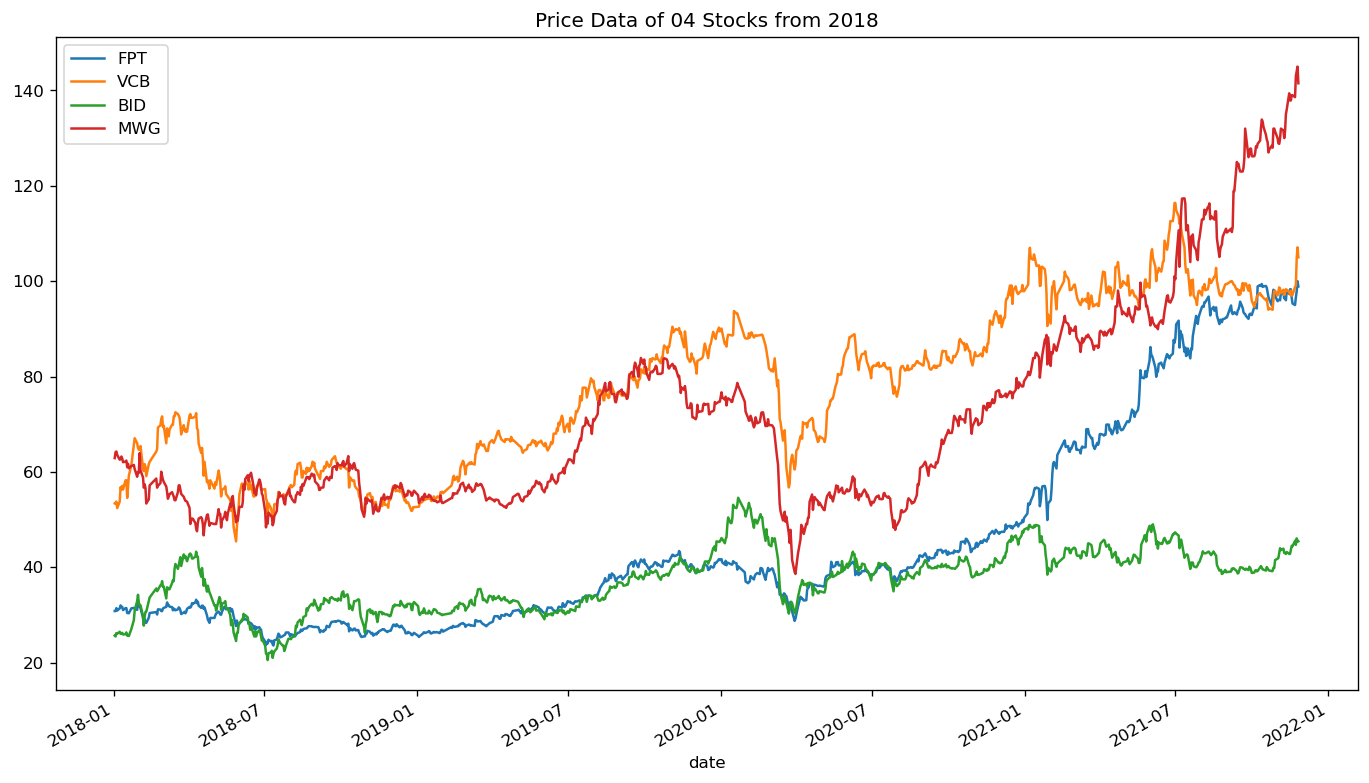

In [13]:
for ticker in vn04_tickers:
  df[df['ticker'] == ticker]['close'].loc[:'2018-01-01'].plot(title='Price Data of 04 Stocks from 2018')

plt.legend(vn04_tickers)

In [14]:
FPT = df[df['ticker'] == 'FPT'][['close','simple_return','log_return']]

In [24]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=FPT.index, y=FPT.close, name="Close price",line={'color': 'black'},showlegend=True),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=FPT.index, y=FPT.simple_return, name="Returns",line={'color': 'blue'},opacity=.5),
    secondary_y=True,
)

fig.update_layout(title = '<b>FPT Stock</b>')
# Set x-axis title
fig.update_xaxes(title_text="<b>Year</b>")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Price</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Returns</b>", secondary_y=True)
fig.show()

### Histogram

In [15]:
fig = make_subplots(rows=2, cols=3, column_widths=[0.4,0.4,0.4],row_heights=[0.6,0.6])
  
fig.add_trace(go.Box(x=FPT.close,name ='Price',marker_color='rgb(16, 154, 246)'),
     row=1, col=1)
fig.add_trace(go.Box(x=FPT.simple_return,name ='Simple returns',marker_color='rgb(246, 52, 16)'),
    row=1, col=2)
fig.add_trace(go.Box(x=FPT.log_return,name ='Log returns',marker_color='rgb(0, 0, 255)'),
    row=1, col=3)

fig.add_trace(go.Histogram(x=FPT.close,
  marker_color='rgb(16, 154, 246)',name ='Price',showlegend=False), 
  row=2, col=1)
fig.add_trace(go.Histogram(x=FPT.simple_return,
  marker_color='rgb(246, 52, 16)',name ='Simple returns',showlegend=False), 
  row=2, col=2)
fig.add_trace(go.Histogram(x=FPT.log_return,
  marker_color='rgb(0, 0, 255)',name ='Log returns',showlegend=False), 
  row=2, col=3)
fig.update_layout(height=400, width=1300, title_text='FPT Stock')

### Bollinger band

In [15]:
FPT['sma'] = FPT.close.rolling(window=20).mean()
FPT['std'] = FPT.close.rolling(window=20).std()

In [16]:
FPT['upper'] = FPT.sma + 2*FPT['std']
FPT['lower'] = FPT.sma - 2*FPT['std']

In [17]:
FPT.tail()

close  simple_return  log_return        sma       std  \
date                                                                    
2006-12-19  23.359288      -0.047059   -0.048202  23.419369  1.678083   
2006-12-18  22.253808      -0.047325   -0.048482  23.142999  1.343768   
2006-12-15  21.196391      -0.047516   -0.048682  22.878644  1.159433   
2006-12-14  20.187039      -0.047619   -0.048790  22.626307  1.169028   
2006-12-13  19.225752      -0.047619   -0.048790  22.385985  1.345520   

                upper      lower  
date                              
2006-12-19  26.775535  20.063203  
2006-12-18  25.830535  20.455462  
2006-12-15  25.197510  20.559779  
2006-12-14  24.964362  20.288251  
2006-12-13  25.077025  19.694944

In [18]:
FPT['bolinger_buy_signal'] = np.where(FPT.lower > FPT.close, True, False)
FPT['bolinger_sell_signal'] = np.where(FPT.upper > FPT.close, True, False)

In [19]:
FPT.dropna(subset=['sma'], inplace=True)

In [20]:
df_bollinger = df[df['ticker'] == 'FPT']

In [21]:
def plot_bollinger(prices,title):
    fig = go.Figure()
    layout = go.Layout(title=title)

    fig.add_traces(go.Scatter(
        name='close',
        x=prices.index,
        y=prices.close,
        line={'color': 'black'}))
    fig.add_traces(go.Scatter(
        name='monthly_sma',
        x=prices.index,
        y=prices.sma,
        line={'color': 'red'}))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.upper,
        name='monthly_bollinger_high_band',
        fill=None,
        line={'color':'#2D3ECF'},showlegend=True))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.lower,
        name='monthly_bollinger_low_band',
        fill='tonexty',
        fillcolor='rgba(0,250,0,0.3)',
        line={'color': '#B6B2CF'},showlegend=True))

    pyo.iplot({'data': fig, 'layout': layout})

In [22]:
plot_bollinger(FPT.loc[:'2019-01-01'],'FPT Bollinger band')

### High-low band (breakout)

In [23]:
close = df.reset_index().pivot(index='date', columns='ticker', values='close')
high = df.reset_index().pivot(index='date', columns='ticker', values='high')
low = df.reset_index().pivot(index='date', columns='ticker', values='low')

In [24]:
lookback_days = 20
lookback_high, lookback_low = functions.get_high_lows_lookback(high, low, lookback_days)
visualizations.plot_high_low(
    close['FPT'].iloc[3000:],
    lookback_high['FPT'].iloc[3000:],
    lookback_low['FPT'].iloc[3000:],'FPT',
    'High and Low of {} Stock'.format('FPT'))

### View time series/cross sectional for pattern recognition

#### Time series analysis
[Momentum Strategy](https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/)

In [11]:
monthly_close = functions.resample_prices(df['close'])
monthly_returns = functions.compute_log_returns(monthly_close)
prev_returns = functions.shift_returns(monthly_returns, 1)
lookahead_returns = functions.shift_returns(monthly_returns, -1)

In [26]:
from scipy.stats import linregress

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [27]:
momentums = close.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = close[ticker].rolling(20).apply(momentum, raw=False)


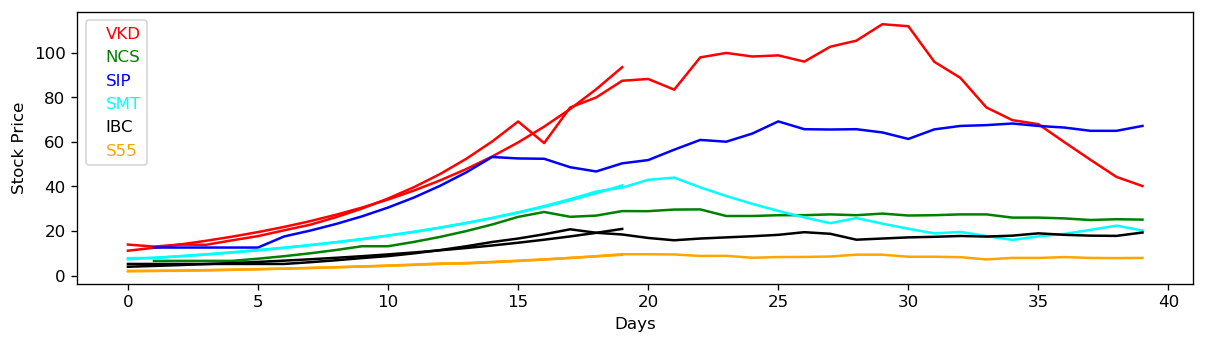

In [69]:
fig = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
# plt.figure(figsize=(12,3))
plt.xlabel('Days')
plt.ylabel('Stock Price')

colors = ['red','green','blue','cyan','black','orange']
bests = momentums.max().sort_values(ascending=False).index[:6]

for color, best in zip(colors,bests):
    end = momentums[best].index.get_loc(momentums[best].idxmax()) #return index of the first maximum value
    rets = np.log(close[best].iloc[end - 20 : end])
    x = np.arange(len(rets)) #20 days
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    ax.plot(np.arange(40), close[best][end-20:end+20], color=color)
    ax.plot(x, np.e ** (intercept + slope*x), color=color)
    
leg = ax.legend(bests,handlelength=0)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
plt.show()

#### Cross sectional analysis

In [16]:
# df.set_index('date') # Set the date as the index so we can add the index mean returns for that day

df['index_mean_simple_return'] =  df.groupby('date')['simple_return'].apply(lambda x: x.mean())#We are using apply here instead of transform because apply can handle grouped outputs 

df['index_mean_log_return'] =  df.groupby('date')['log_return'].apply(lambda x: x.mean())

df['demeaned_return']  = df['simple_return'] - df['index_mean_simple_return']
df['demeaned_log_return']  = df['log_return'] - df['index_mean_log_return']

# df.reset_index(inplace=True)#Reset index making the date a column again (lets us use it in calculations)

In [88]:
df_1m = df.resample('M').last()
df_3m = df.resample('Q').last()
df_6m = df.resample('6M').last()
df_12m = df.resample('A').last()

In [12]:
df['3m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 60)) #three months returns
df['12m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 220)) # yearly returns

In [13]:
df['target-1'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-1)/target)) #One day ahead
df['target-2'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-5)/target)) #One week ahead
df['target-3'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-20)/target)) #One month ahead
df['target-4'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-60)/target)) #One quarter ahead
df['target-5'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-120)/target)) #One half ahead

In [87]:
df[df['ticker'] == 'FPT'].tail(2)

open       high        low      close  volume  unadjusted  \
date                                                                         
2006-12-14  20.187039  20.187039  20.187039  20.187039  280710       420.0   
2006-12-13  19.225752  19.225752  19.225752  19.225752   83530       400.0   

            putthrough ticker  year  quarter  ...  demeaned_log_return  \
date                                          ...                        
2006-12-14           0    FPT  2006        4  ...            -0.017865   
2006-12-13           0    FPT  2006        4  ...            -0.028213   

                  3m       12m  target-1  target-2  target-3  target-4  \
date                                                                     
2006-12-14 -0.320264  0.075417  -0.04879       NaN       NaN       NaN   
2006-12-13 -0.369055 -0.000246       NaN       NaN       NaN       NaN   

            target-5  3m_bucket  12m_bucket  
date                                         
2006-12-14       NaN        0.0         6.0  
2006-12-13       NaN        0.0         5.0  

[2 rows x 26 columns]

In [14]:
momentum_factor = pd.pivot_table(df,index='3m',values=['target-1','target-2','target-3','target-4','target-5'],aggfunc='mean')

In [24]:
momentum_factor.head()

target-1  target-2  target-3  target-4  target-5
3m                                                         
-inf            inf       inf       inf       inf       NaN
-2.796751 -0.021979 -0.044452 -0.021979 -0.090972 -0.165080
-2.788093  0.022473  0.022473  0.022473 -0.257829 -0.046520
-2.787751  0.000000  0.000000  0.000000 -0.280302 -0.068993
-2.740840  0.022473  0.022473  0.065958 -0.228842  0.022473

In [15]:
#Create 10 quantiles on 3months, 12moths retunrs
df['3m_bucket'] = functions.bucketing_factors(df['3m'],10)
df['12m_bucket'] = functions.bucketing_factors(df['12m'],10)

In [33]:
vn30_tickers = ['STB', 'VIC','SSI','MSN', 'FPT','NVL','TCB','PDR','PLX','VNM','REE','CTG','GAS',
  'VCB','VHM','PNJ','TCH','HPG','TPB','HDB','VPB','MWG','VJC','BID','BVH','VRE','SBT','KDH','MBB','POW']

df_vn30 = pd.DataFrame()
for ticker in vn30_tickers:
  df_vn30 = pd.concat([df_vn30,df[df['ticker'] == ticker]],ignore_index=False)

In [16]:
df_vn04 = pd.DataFrame()
for ticker in vn04_tickers:
  df_vn04 = pd.concat([df_vn04,df[df['ticker'] == ticker]],ignore_index=False)

In [47]:
df_vn30[df_vn30['ticker'] == 'FPT'].loc['2012-12-20']

open      high       low     close  volume  unadjusted  \
date                                                                     
2012-12-20  7.409906  7.409906  7.255073  7.255073   71260        32.8   

            putthrough ticker  year  quarter  ...  demeaned_log_return  \
date                                          ...                        
2012-12-20           0    FPT  2012        4  ...             0.005542   

                 3m       12m  target-1  target-2  target-3  target-4  \
date                                                                    
2012-12-20 -0.16023 -0.373758  0.015129  0.012121  0.002024  0.116195   

            target-5  3m_bucket  12m_bucket  
date                                         
2012-12-20  0.308964        2.0         2.0  

[1 rows x 26 columns]

<AxesSubplot:title={'center':'Factor of 3m_bucket'}, xlabel='3m_bucket'>

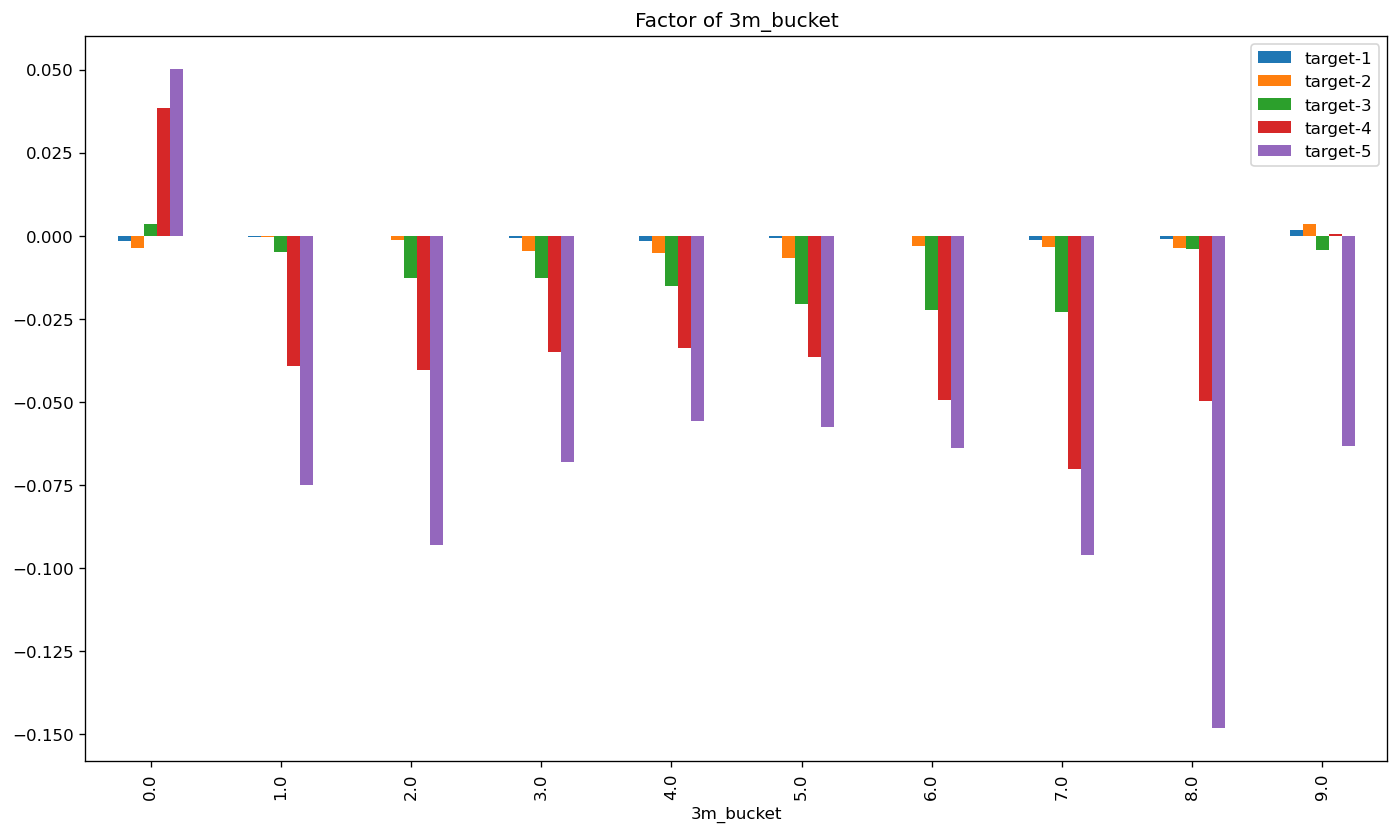

In [25]:
visualizations.plot_bar(df_vn04, '3m_bucket')

<AxesSubplot:title={'center':'Factor of 12m_bucket'}, xlabel='12m_bucket'>

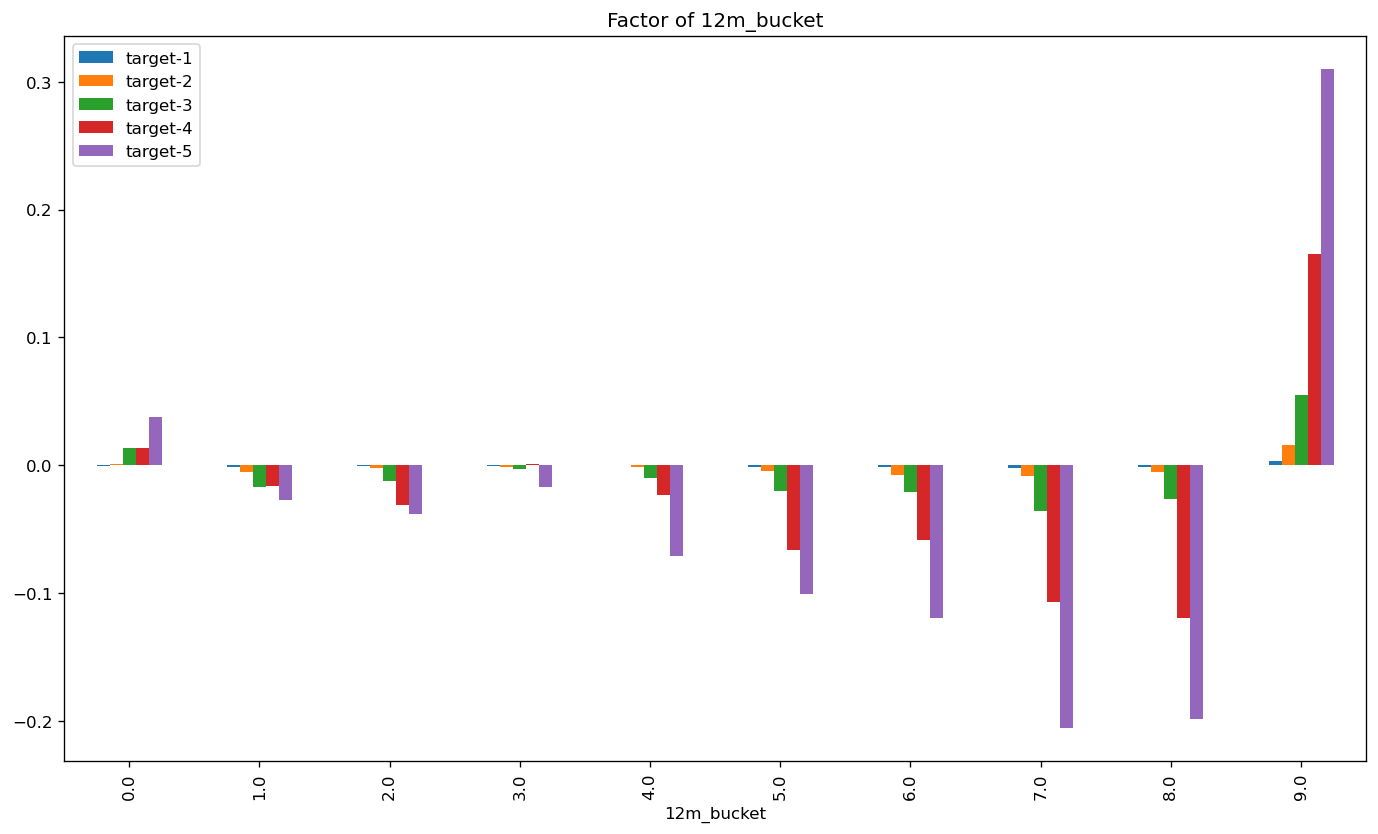

In [26]:
visualizations.plot_bar(df_vn04, '12m_bucket')

In [30]:
momen_factor_year = pd.pivot_table(df_vn04,index=['12m_bucket','year'],values='target-5',aggfunc='mean').reset_index()

In [31]:
momen_factor_year['annualised'] = momen_factor_year['target-5']*252

In [33]:
#10 quantiles in 16 years
print(momen_factor_year)

     12m_bucket  year  target-5  annualised
0           0.0  2008  0.901068  227.069070
1           0.0  2009  0.634657  159.933559
2           0.0  2013 -0.103048  -25.968095
3           0.0  2014  0.064006   16.129422
4           0.0  2015  0.201599   50.802979
..          ...   ...       ...         ...
102         8.0  2015 -0.395638  -99.700862
103         8.0  2018 -0.765134 -192.813828
104         8.0  2019 -0.341425  -86.039157
105         9.0  2007  0.307179   77.409122
106         9.0  2008  0.318079   80.156023

[107 rows x 4 columns]


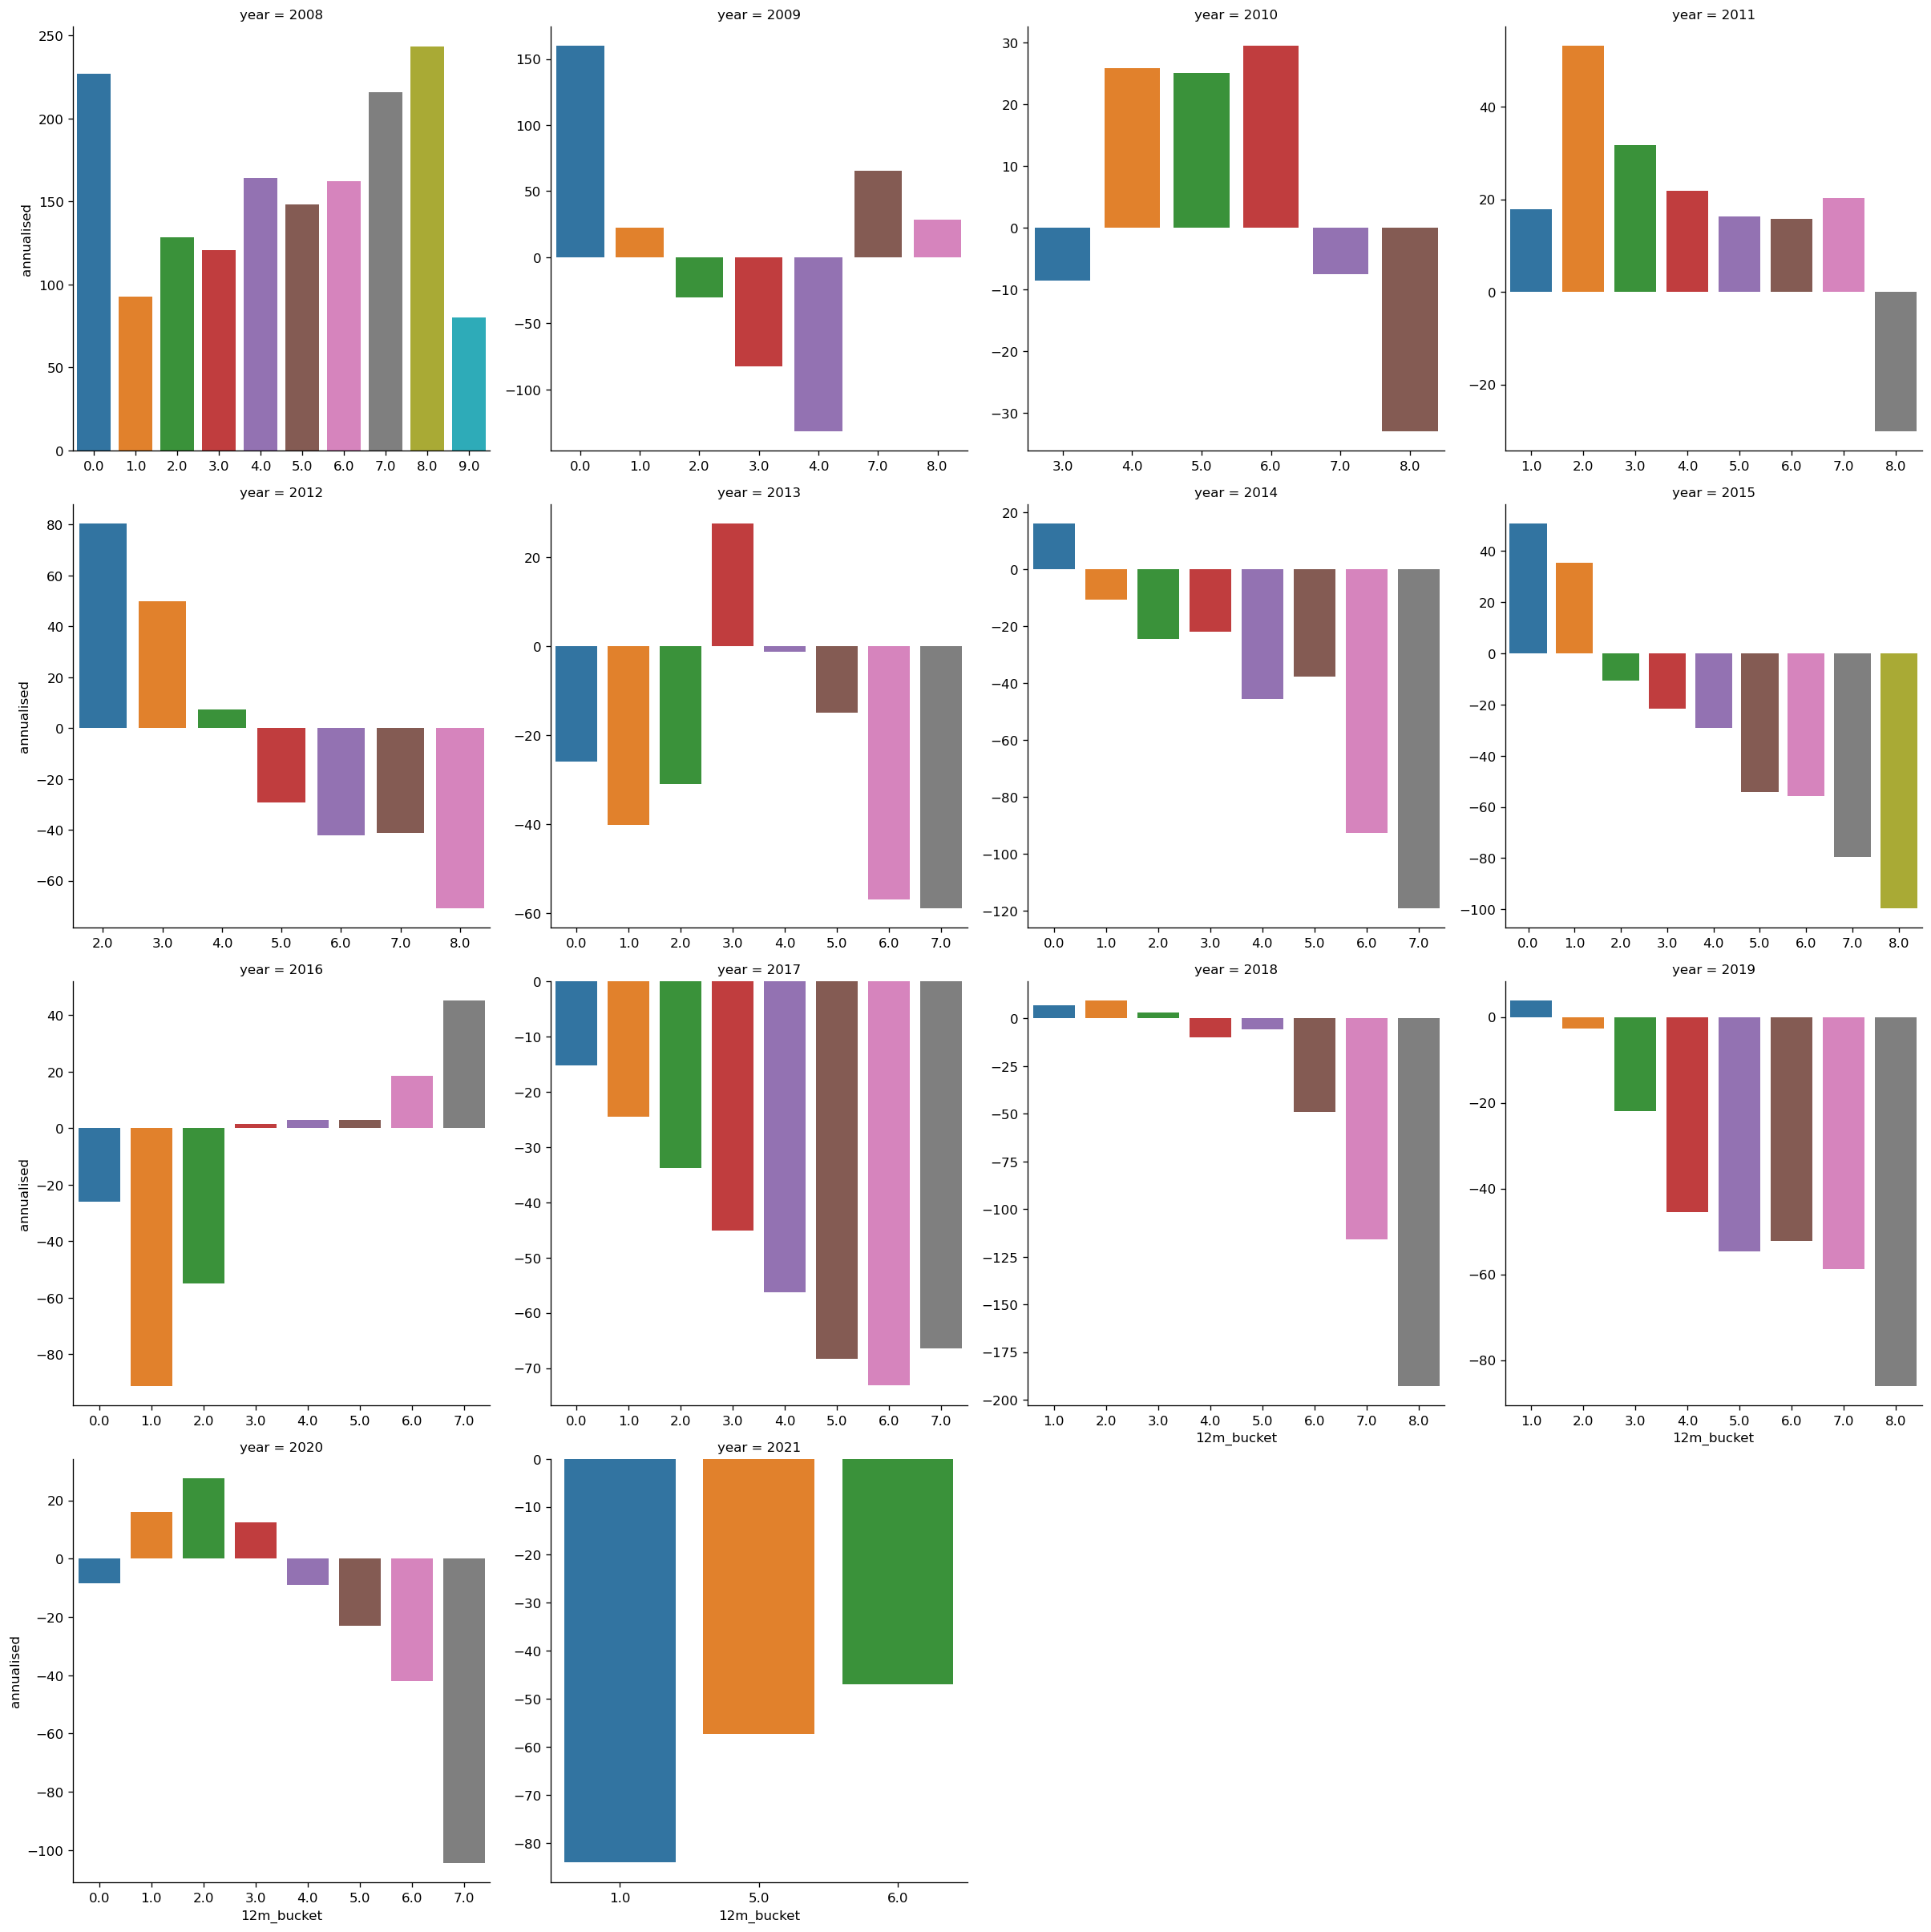

In [39]:
# plt.figure(figsize=[15,4])
plt.rcParams['figure.figsize'] = [10, 4]
sns.catplot(x='12m_bucket',y='annualised',data=momen_factor_year[momen_factor_year['year'] != 2007],kind='bar',col='year',col_wrap=4,sharey=False,sharex=False);

### Hypothesis refinement

Weekly,monthly, quarterly, halfly & yearly momentum indicators have been observed both in time series & cross sectional analysis, they are considered as the long-term alpha factors. The other indicators such as mean reversion & overnight sentiment - seasonality, both are short-time factors, are also taken into account in the model.

<h2>3. Model construction</h2>

<p>Risk model will be built on stock returns data under CAPM theory to calculate: factor_betas, factor_returns, factor_cov_matrix, idiosyncratic_var_matrix and idiosyncratic_var_vector to compute the portfolio risk. It then will be used as the constrain factors for alpha operation in the weight optimization process of multi-factor model </p>

<p>A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue and sell stocks showing a weak upward trend, even downward one in a specific time window. Momentum indicator is only used for ranking the stocks, not for price prediction.  
Momentum is almost the opposite of the mean-reversion effect, accompany with seasonality as the key resilient factors for alpha model.</p>

<p>Alpha model operating under risk factors & weight scheme influences will be a real-world alpha simulation, from that point investors/trader/portfolio managers can quantitatively design their own strategies & backtests that allows them make up their further decision</p>

### Candidate selection
This is a pretty high level research covering the whole VN stock exchange, so the project will handle 621 exchange-traded stocks, take 10 years historic data from 2011-09-01 to 2021-09-01

<h3>Quantopian zipline & alphalens</h3>
<p>Quantopian is a back testing and implementation system. It allows a user to create a systematic investment strategy in Python, backtest it, and live trade it via a link to Interactive Brokers</p>
<h4>Zipline data ingestion & bundle construction</h4>  
<a href=https://github.com/quantopian/zipline>Zipline</a> - supports both backtesting and live trading:<br>
  - <a href=https://github.com/quantopian/zipline/tree/master/zipline/pipeline>Pipeline</a>:  Real-time streaming sercurities data from database, filtering stock data according to factors.<br>
<a href=https://github.com/quantopian/alphalens>Alphalens</a>:  performance analysis of predictive (alpha) stock factors<br>


##### Data Bundle
bundle file is a python file that defines an ingest function with a specific signature that Zipline uses when running the zipline ingest command
- ingest function:  
  - Format the data  
  - Create the metadata  
  - Write the daily bars  
  - Store the adjustments

We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal
import functions

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'project_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], 'eod-quotemedia')
bundles.register('eod-quotemedia', ingest_func)

print('Data Registered')

Data Registered


#### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
universe = AverageDollarVolume(window_length=120).top(621) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load('eod-quotemedia')
engine = functions.build_pipeline_engine(bundle_data, trading_calendar)

With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [4]:
universe_end_date = pd.Timestamp('2021-09-01', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers[:5]

[Equity(0 [AAA]),
 Equity(1 [AAV]),
 Equity(2 [ABC]),
 Equity(3 [ABI]),
 Equity(4 [ABS])]

#### Get Prices & Returns
Building a data portal from pipeline engine.

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

Get daily returns for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [8]:
ten_year_prices = get_pricing(
        data_portal,trading_calendar,universe_tickers,
        universe_end_date - pd.DateOffset(years=10),
        universe_end_date)

In [9]:
ten_year_returns = ten_year_prices.pct_change()[1:].fillna(0)
ten_year_returns.tail(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
2021-08-31 00:00:00+00:00         0.002558         0.065728         0.046875   
2021-09-01 00:00:00+00:00         0.033163         0.092511         0.037313   

                           Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
2021-08-31 00:00:00+00:00        -0.025487        -0.022222              0.0   
2021-09-01 00:00:00+00:00        -0.007692         0.012626              0.0   

                           Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
2021-08-31 00:00:00+00:00        -0.004666         0.009967         0.000000   
2021-09-01 00:00:00+00:00         0.000000         0.013158         0.013514   

                           Equity(9 [ACL])        ...          \
2021-08-31 00:00:00+00:00         0.007782        ...           
2021-09-01 00:00:00+00:00        -0.011583        ...           

                           Equity(611 [VTO])  Equity(612 [VTP])  \
2021-08-31 00:00:00+00:00          -0.027650          -0.004884   
2021-09-01 00:00:00+00:00           0.028436           0.002454   

                           Equity(613 [VTR])  Equity(614 [VXP])  \
2021-08-31 00:00:00+00:00          -0.003311                0.0   
2021-09-01 00:00:00+00:00           0.000000                0.0   

                           Equity(615 [WCS])  Equity(616 [WSB])  \
2021-08-31 00:00:00+00:00           0.011050           0.018367   
2021-09-01 00:00:00+00:00          -0.010929          -0.008016   

                           Equity(617 [X26])  Equity(618 [YBM])  \
2021-08-31 00:00:00+00:00                0.0           0.000000   
2021-09-01 00:00:00+00:00                0.0           0.039437   

                           Equity(619 [YEG])  Equity(620 [YTC])  
2021-08-31 00:00:00+00:00           0.022876                0.0  
2021-09-01 00:00:00+00:00          -0.003195                0.0  

[2 rows x 621 columns]

### 3.1. Statistical Risk Model
Under CAPM theory, let's build a statistical risk model using PCA. So, the first thing is building the PCA model.

#### Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

Let's see what the model looks like. First, we'll look at the PCA components.

In [17]:
num_factor_exposures = 20 
pca = rmf.fit_pca(ten_year_returns, num_factor_exposures, 'full') #fit_pca compute factor exposure = pca.component_

pca.components_.shape #20 is num of rows (observations) which is reduced from 1256rows before PCA

(20, 621)

In [11]:
pca.explained_variance_ratio_.sum()

0.23086707069062726

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 20 artists>

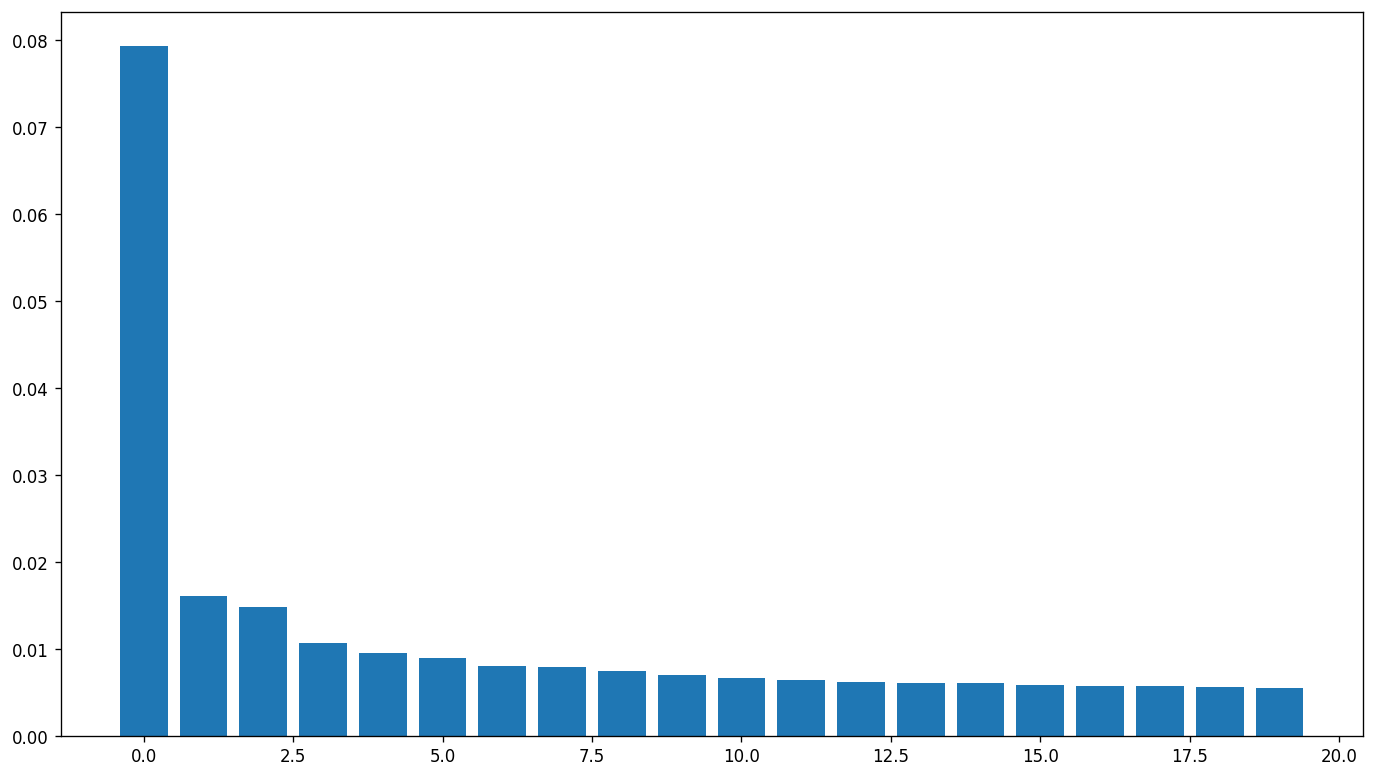

In [10]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

The first factor/principal comonent is dominent. The precise definition of each factor in the latent model is unknown, however we can see the contribution of stocks to each component.

In [13]:
#Find the tickers contribute the most to the first principal component
top5_pc1 = np.argpartition(np.abs(pca.components_[0]), -5)[-5:]
print(top5_pc1,'\n', pca.components_[0][top5_pc1])

[572 237 420 443 355] 
 [-0.0962392  -0.10276275 -0.0975542  -0.11711553 -0.10182904]


In [16]:
ten_year_returns[top5_pc1].columns

Index([Equity(572 [VIG]), Equity(237 [HUT]), Equity(420 [SCR]),
       Equity(443 [SHS]), Equity(355 [PFL])],
      dtype='object')

#### Factor Betas (factor exposure)

Factor Betas is the exposure of each asset in the universe to each component in PCA. Note that this is not exposures of your portfolio but the universe:

In [12]:
#risk_model: factor_betas,factor_returns,factor_cov_matrix,idiosyncratic_var_matrix,idiosyncratic_var_vector
risk_model = {}
#factor_betas(pca, factor_beta_indices, factor_beta_columns)
risk_model['factor_betas'] = rmf.factor_betas(pca, ten_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'].head(2) # 621(tickers) rows & 20(factors) columns

0         1         2         3         4         5   \
Equity(0 [AAA]) -0.075863 -0.004677  0.002022 -0.033789 -0.009032  0.005992   
Equity(1 [AAV]) -0.024112  0.045659 -0.033518  0.009183 -0.014575 -0.002554   

                       6         7         8         9         10        11  \
Equity(0 [AAA])  0.001046  0.020531  0.022267  0.006952 -0.008712 -0.001285   
Equity(1 [AAV])  0.000264 -0.020054 -0.010048  0.013332  0.009383  0.006218   

                       12        13        14        15        16        17  \
Equity(0 [AAA]) -0.025567 -0.017284  0.001129  0.004876 -0.003481  0.008329   
Equity(1 [AAV])  0.000852  0.025287  0.003902  0.010797  0.019325 -0.014445   

                       18        19  
Equity(0 [AAA]) -0.005341 -0.011347  
Equity(1 [AAV]) -0.012384 -0.018536

#### Factor Returns from asset returns
Returns of each risk factor (20 components of PCA)

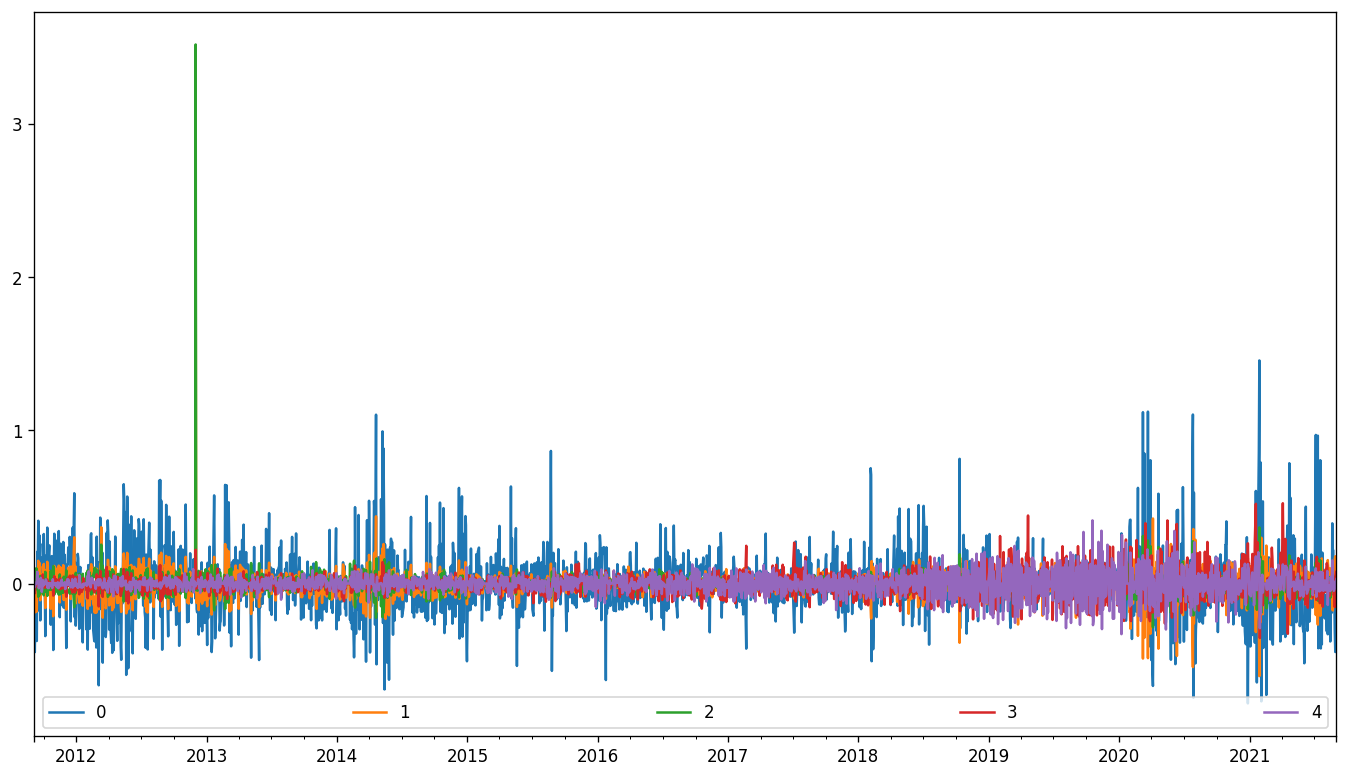

In [23]:
#factor_returns(pca, returns, factor_return_indices, factor_return_columns)
risk_model['factor_returns'] = rmf.factor_returns(
    pca,
    ten_year_returns,
    ten_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].iloc[:,:5].plot(legend=True) # 20 PCs (factors) returns by time (1256days)
plt.legend(loc="lower left", mode = "expand",ncol = len(risk_model['factor_returns'].columns) )

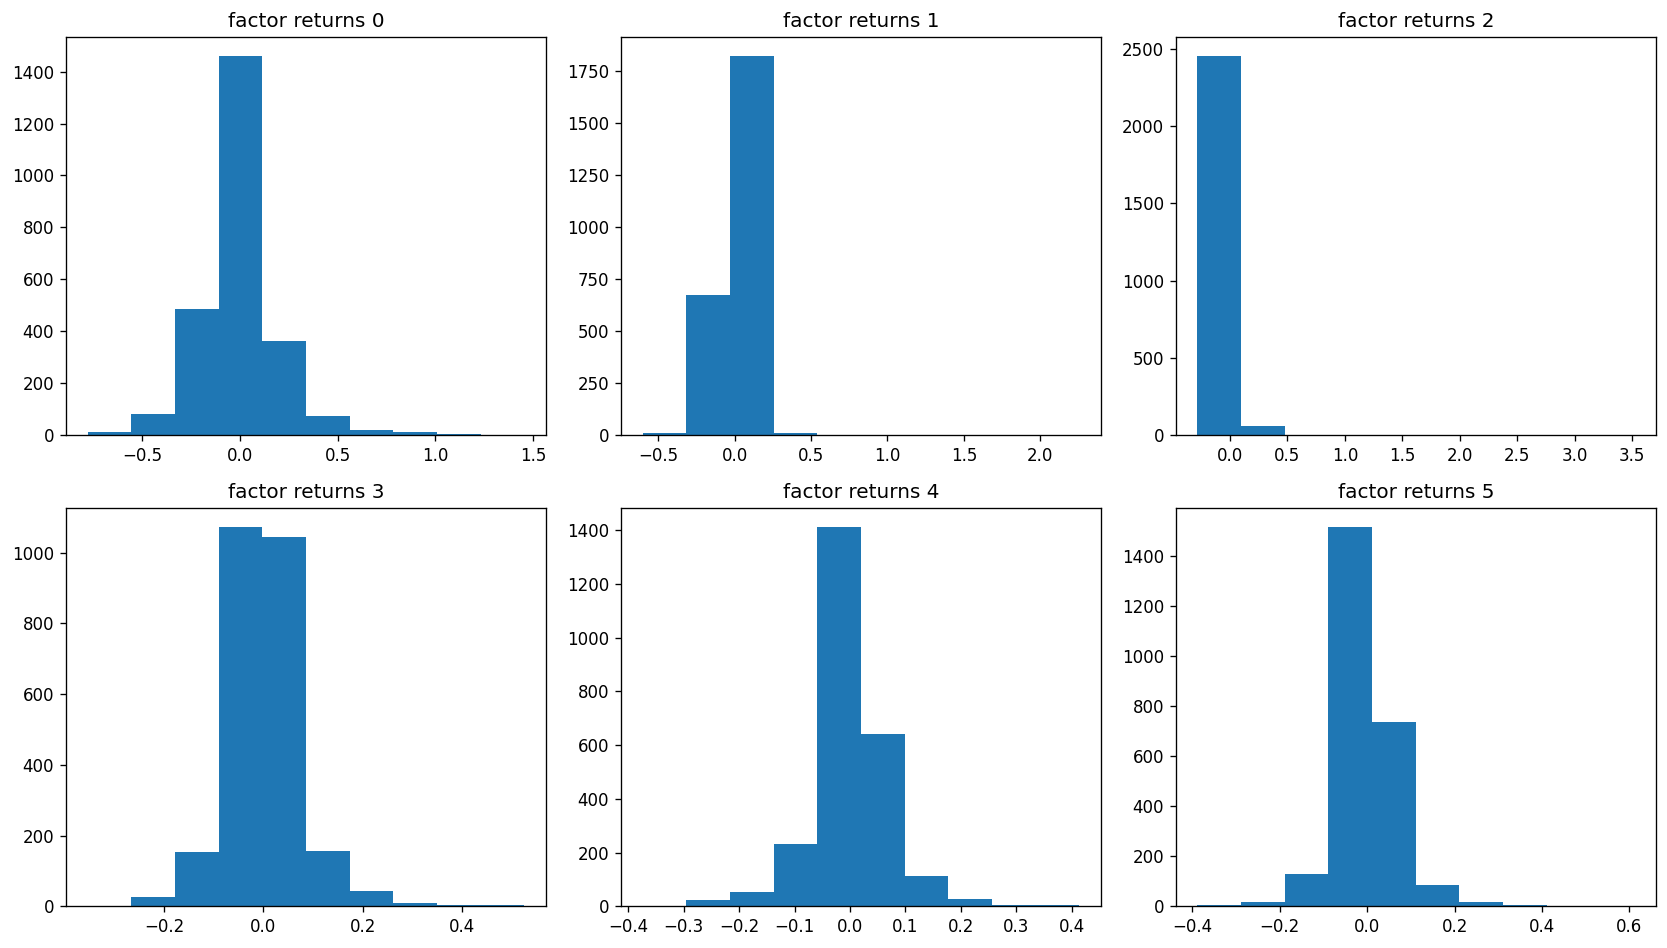

In [24]:
f,a = plt.subplots(2,3)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(risk_model['factor_returns'].loc[:,idx].values.tolist())
    ax.set_title('factor returns {}'.format(idx))
#     ax.set_xlabel(xaxes[idx])
#     ax.set_ylabel(yaxes[idx])
plt.tight_layout()

#### Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [25]:
ann_factor = 252
risk_model['factor_cov_matrix'] = rmf.factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[9.83160205, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.00233948, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.83927457, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.33369941, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [18]:
np.shape(risk_model['factor_cov_matrix'])

(20, 20)

#### Idiosyncratic Variance Matrix (specific return)
Residuals that are not explained by the 20 factors are considered as idiosyncratic to each asset

In [26]:
#idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor)
risk_model['idiosyncratic_var_matrix'] = rmf.idiosyncratic_var_matrix(ten_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
Equity(0 [AAA])         0.092997          0.00000              0.0   
Equity(1 [AAV])         0.000000          0.08326              0.0   

                 Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
Equity(0 [AAA])              0.0              0.0              0.0   
Equity(1 [AAV])              0.0              0.0              0.0   

                 Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
Equity(0 [AAA])              0.0              0.0              0.0   
Equity(1 [AAV])              0.0              0.0              0.0   

                 Equity(9 [ACL])        ...          Equity(611 [VTO])  \
Equity(0 [AAA])              0.0        ...                        0.0   
Equity(1 [AAV])              0.0        ...                        0.0   

                 Equity(612 [VTP])  Equity(613 [VTR])  Equity(614 [VXP])  \
Equity(0 [AAA])                0.0                0.0                0.0   
Equity(1 [AAV])                0.0                0.0                0.0   

                 Equity(615 [WCS])  Equity(616 [WSB])  Equity(617 [X26])  \
Equity(0 [AAA])                0.0                0.0                0.0   
Equity(1 [AAV])                0.0                0.0                0.0   

                 Equity(618 [YBM])  Equity(619 [YEG])  Equity(620 [YTC])  
Equity(0 [AAA])                0.0                0.0                0.0  
Equity(1 [AAV])                0.0                0.0                0.0  

[2 rows x 621 columns]

#### Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [27]:
#idiosyncratic_var_vector(returns, idiosyncratic_var_matrix)
risk_model['idiosyncratic_var_vector'] = rmf.idiosyncratic_var_vector(ten_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector'].head(2)

0
Equity(0 [AAA])  0.092997
Equity(1 [AAV])  0.083260

<AxesSubplot:>

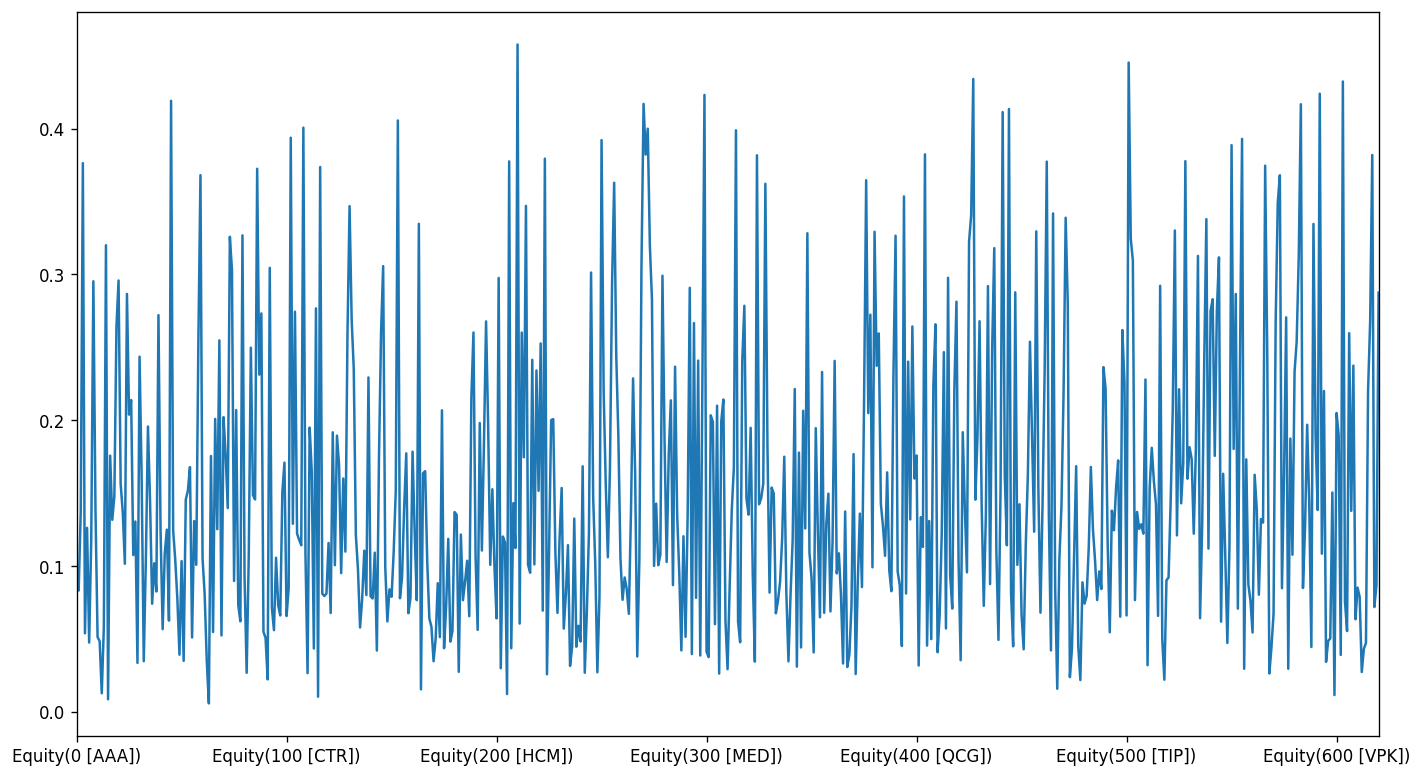

In [30]:
risk_model['idiosyncratic_var_vector'].plot(legend=None)

#### Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Assuming the portfolio evenly distribute the holdings to all the stocks in the universe, the portfolio risk can be calculated like this:

In [28]:
#assume equal weight for every stock
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

#predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights)
rmf.predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.10517001637803534

<h3>3.3. Alpha model</h3>
Alpha factors and risk factors can be interchangeable by time and markets. Once alpha becomes publicly known and available, its profitable power will decrease and turn to be a risk factor and vice versa.

### Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year, 1 Half Year, 1 Quarter, 1 Month, 1 Week Factors
- Mean Reversion 5Days, 20Days Sector Neutral Factors
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor  

Each factor will have a hypothesis that goes with it. 

#### Momentum Factors
Momentum function uses the returns data from `universe` (621 tickers), they are demeaned by sector to be sector neutral, ranking, then converted to a zscore to avoid trading too much by normalisation:  
- Yearly momentum hypothesis: it is "Higher past 12-months (252 days) returns are proportional to future return." 
- Halfly momentum hypothesis: it is "Higher past 6-months (120 days) returns are proportional to future return." 
- Quarterly momentum hypothesis: it is "Higher past 3-months (60 days) returns are proportional to future return." 
- Monthly momentum hypothesis: it is "Higher past 1-month (20 days) returns are proportional to future return." 
- Weekly momentum hypothesis: it is "Higher past 1-week (5 days) returns are proportional to future return." 

#### Mean Reversion Factors
Mean reversion theory states that security prices and economic indicators such as interest rates will tend to revert to the historical mean prices.  
- Mean_reversion_5day hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe` (621 tickers), ranking, then converted to a zscore.  
- Mean_reversion_5days_smoothed is a smoothed version of Mean_reversion_5day factor using `SimpleMovingAverage` function. It is also applied rank and zscore again.
- Mean_reversion_20day hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe` (621 tickers), ranking, then converted to a zscore.

#### Seasonality Factors
Numerous traders have noticed that the US stocks have significantly higher return during the night session compared to the daily session. Multiple academic studies have confirmed this suspicion and found that the US equity premium is mostly due to overnight returns. This notion is called an [overnight anomaly](https://quantpedia.com/market-sentiment-and-an-overnight-anomaly/)  
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).
- Overnight Sentiment
- Overnight Sentiment Smoothed

#### Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

For calculating factors, we'll be looking back 5 years.

**Note:** _The last day of the data (2021-09-01) is usually a public holiday in VN, Going back 5 years might fall on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days (August has no public holiday) to fall on the next day when the market is open._

In [10]:
universe = AverageDollarVolume(window_length=120).top(621)
factor_start_date = universe_end_date - pd.DateOffset(years=5, days=2)
sector = functions.Sector()

In [11]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    amf.momentum(252, universe),
    'Momentum_1YR')
pipeline.add(
    amf.momentum(5, universe),
    'Momentum_1WK')
pipeline.add(
    amf.momentum(20, universe),
    'Momentum_1MNT')
pipeline.add(
    amf.momentum(60, universe),
    'Momentum_1QTR')
pipeline.add(
    amf.momentum(120, universe),
    'Momentum_1HLF')
pipeline.add(
    amf.mean_reversion(5, universe),
    'Mean_Reversion_5Day')
pipeline.add(
    amf.mean_reversion_smoothed(5, universe),
    'Mean_Reversion_5Day_Smoothed')
pipeline.add(
    amf.overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    amf.overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])             0.913481   
                          Equity(1 [AAV])                  NaN   
                          Equity(2 [ABC])             0.225404   
                          Equity(3 [ABI])             0.288676   
                          Equity(4 [ABS])                  NaN   

                                           Mean_Reversion_5Day_Smoothed  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                      0.636669   
                          Equity(1 [AAV])                           NaN   
                          Equity(2 [ABC])                      1.593649   
                          Equity(3 [ABI])                      0.423128   
                          Equity(4 [ABS])                           NaN   

                                           Momentum_1HLF  Momentum_1MNT  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.670343      -0.047781   
                          Equity(1 [AAV])            NaN            NaN   
                          Equity(2 [ABC])            NaN            NaN   
                          Equity(3 [ABI])       1.151961       0.342429   
                          Equity(4 [ABS])            NaN            NaN   

                                           Momentum_1QTR  Momentum_1WK  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.438009     -0.913481   
                          Equity(1 [AAV])            NaN           NaN   
                          Equity(2 [ABC])            NaN     -0.225404   
                          Equity(3 [ABI])       0.696850     -0.288676   
                          Equity(4 [ABS])            NaN           NaN   

                                           Momentum_1YR  Overnight_Sentiment  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])      1.667588             0.797693   
                          Equity(1 [AAV])           NaN            -0.502044   
                          Equity(2 [ABC])           NaN            -1.193750   
                          Equity(3 [ABI])      1.108860             1.489398   
                          Equity(4 [ABS])           NaN            -0.496466   

                                           Overnight_Sentiment_Smoothed  
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                      0.546671  
                          Equity(1 [AAV])                     -0.803271  
                          Equity(2 [ABC])                     -0.384901  
                          Equity(3 [ABI])                     -0.407214  
                          Equity(4 [ABS])                     -0.792114

In [15]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

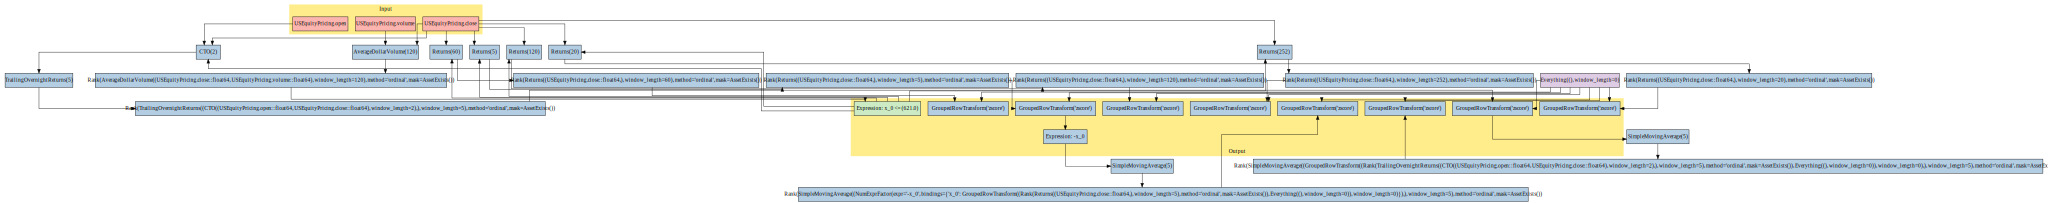

In [16]:
pipeline.show_graph()

### Evaluate Alpha Factors
We have 10 alpha factors so far, we need to assess their performances by using Alphalens functions.  
*Note:* _We're evaluating the alpha factors using delay of 1 day, not the current day_

In [28]:
assets = all_factors.index.levels[1].values.tolist() # get index from alpha fattors
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets, 
    factor_start_date,
    universe_end_date)

#### Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. 

In [6]:
import alphalens as al

#convert factors & prices to alphalen data format, return A MultiIndex Series (DF)
##indexed by date (level 0) and asset (level 1)...https://quantopian.github.io/alphalens/alphalens.html
#calculate 1day returns, 1day factor returns & classify to quantiles
clean_factor_data = { 
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

#convert y-m-d index format to seconds from 1970-01-01 UTC
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 17.0% entries from factor data: 17.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 16.5% entries from factor data: 16.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 13.2% entries from factor data: 13.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 19.3% entries from factor data: 19.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 17.0% entries from factor data: 17.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropp

#### Quantile Analysis
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [10]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].head(2)

1D    factor  factor_quantile
date                      asset                                               
2016-08-31 00:00:00+00:00 Equity(0 [AAA])  0.002877  0.565488                4
                          Equity(2 [ABC])  0.003117 -0.114679                3

In [12]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice['2019-08-30 00:00:00+00:00',:]].head()

1D    factor  factor_quantile
date                      asset                                               
2019-08-30 00:00:00+00:00 Equity(0 [AAA]) -0.027170  1.643886                5
                          Equity(1 [AAV]) -0.017801 -0.927175                2
                          Equity(2 [ABC])  0.031891 -0.841852                2
                          Equity(3 [ABI]) -0.006565 -1.177455                1
                          Equity(5 [ABT])  0.000000 -0.893045                2

In [13]:
unixt_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice[[1567468800.00000000],:]].head()

1D    factor  factor_quantile
date         asset                                               
1.567469e+09 Equity(0 [AAA]) -0.003103  1.126261                5
             Equity(1 [AAV]) -0.018124 -1.422047                1
             Equity(2 [ABC]) -0.030905  0.119452                3
             Equity(3 [ABI]) -0.045217 -1.461864                1
             Equity(5 [ABT]) -0.012832  0.358356                4

In [7]:
ls_factor_returns = pd.DataFrame()

#Computes period wise returns for portfolio weighted by factor values
for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

In [64]:
columnsOrder = ['Momentum_1YR', 'Momentum_1HLF', 'Momentum_1QTR', 'Momentum_1MTH', 'Momentum_1WK', 
       'Mean_Reversion_20Day_Sector_Neutral', 'Mean_Reversion_5Day_Sector_Neutral', 
       'Mean_Reversion_5Day_Sector_Neutral_Smoothed', 'Overnight_Sentiment', 'Overnight_Sentiment_Smoothed']

ls_factor_returns = ls_factor_returns.reindex(columns=columnsOrder)

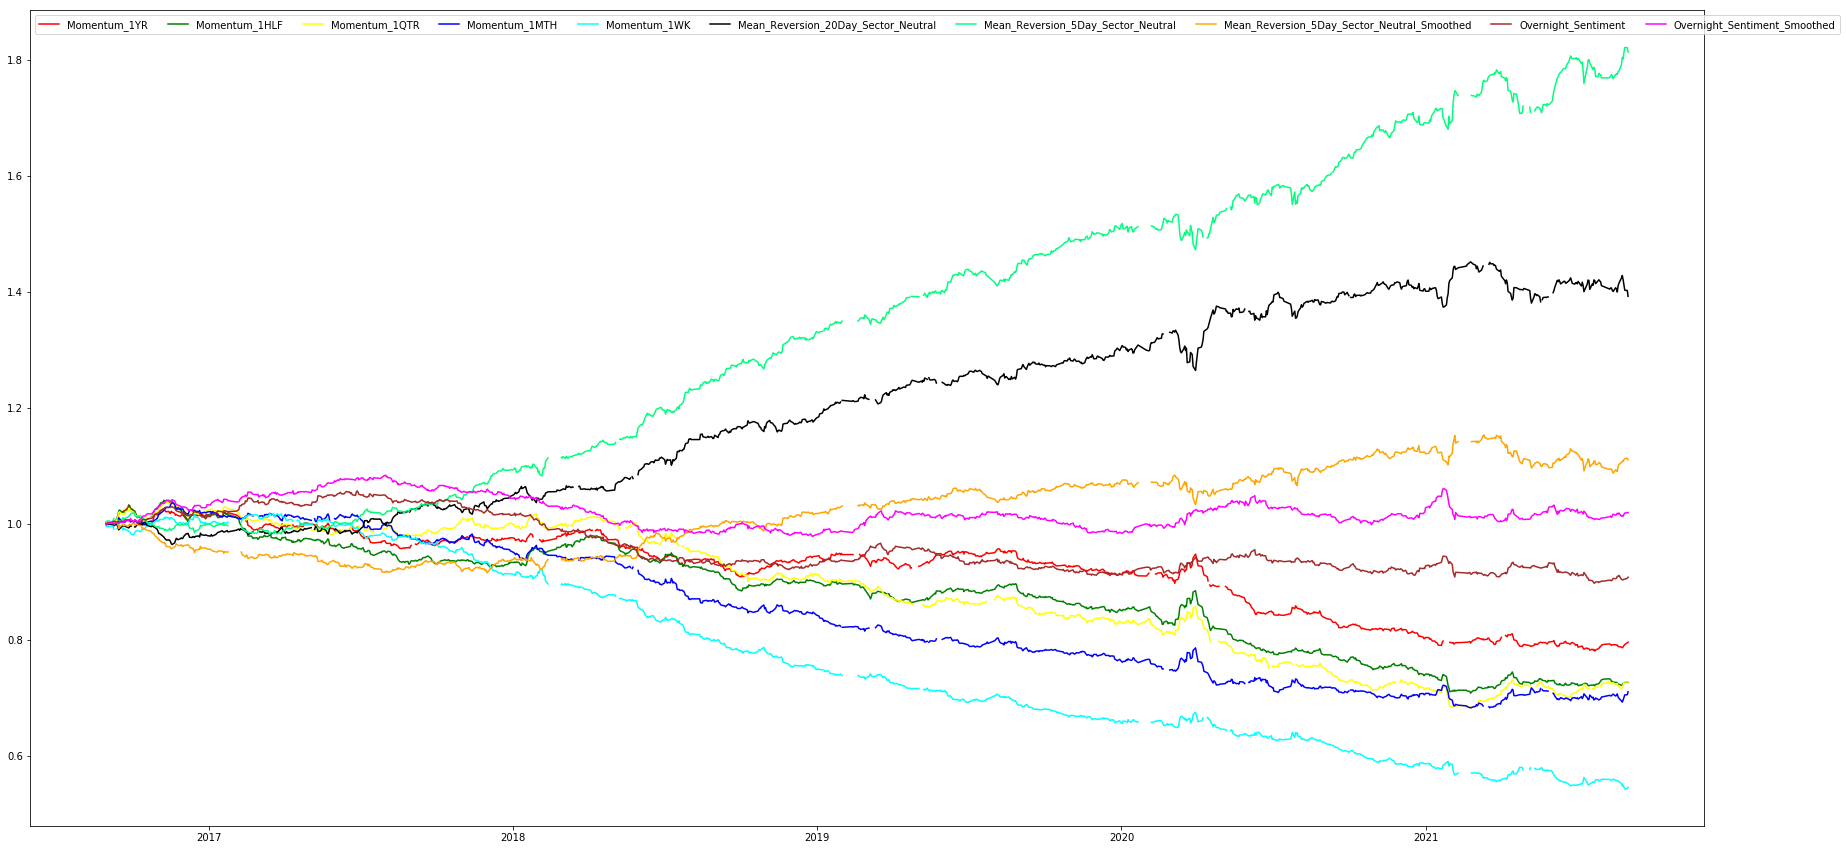

In [66]:
colors = ['red','green','yellow','blue','cyan','black','springgreen','orange','brown','magenta']
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns.columns):
  plt.plot((1+ls_factor_returns[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns.columns,loc="upper left",ncol=len(ls_factor_returns.columns),title_fontsize=20)
plt.show()

In [16]:
ls_factor_returns.head(2)

Mean_Reversion_20Day_Sector_Neutral  \
date                                                             
2016-08-31 00:00:00+00:00                             0.000359   
2016-09-02 00:00:00+00:00                             0.000930   

                           Overnight_Sentiment_Smoothed  Momentum_1HLF  \
date                                                                     
2016-08-31 00:00:00+00:00                     -0.000680       0.002097   
2016-09-02 00:00:00+00:00                      0.001722      -0.002243   

                           Momentum_1YR  Momentum_1WK  Momentum_1MTH  \
date                                                                   
2016-08-31 00:00:00+00:00      0.001313     -0.003843      -0.000359   
2016-09-02 00:00:00+00:00      0.000789     -0.001277      -0.000930   

                           Momentum_1QTR  \
date                                       
2016-08-31 00:00:00+00:00       0.000776   
2016-09-02 00:00:00+00:00      -0.001016   

                           Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
date                                                                     
2016-08-31 00:00:00+00:00                                     0.002977   
2016-09-02 00:00:00+00:00                                    -0.000362   

                           Overnight_Sentiment  \
date                                             
2016-08-31 00:00:00+00:00            -0.001858   
2016-09-02 00:00:00+00:00             0.003700   

                           Mean_Reversion_5Day_Sector_Neutral  
date                                                           
2016-08-31 00:00:00+00:00                            0.003843  
2016-09-02 00:00:00+00:00                            0.001277

#### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [75]:
qr_factor_returns = pd.DataFrame()

#Computes mean returns for factor quantiles across provided forward returns columns
for factor, factor_data in unixt_factor_data.items():
    #get mean returns of each quantile through the time
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

<Figure size 1440x648 with 0 Axes>

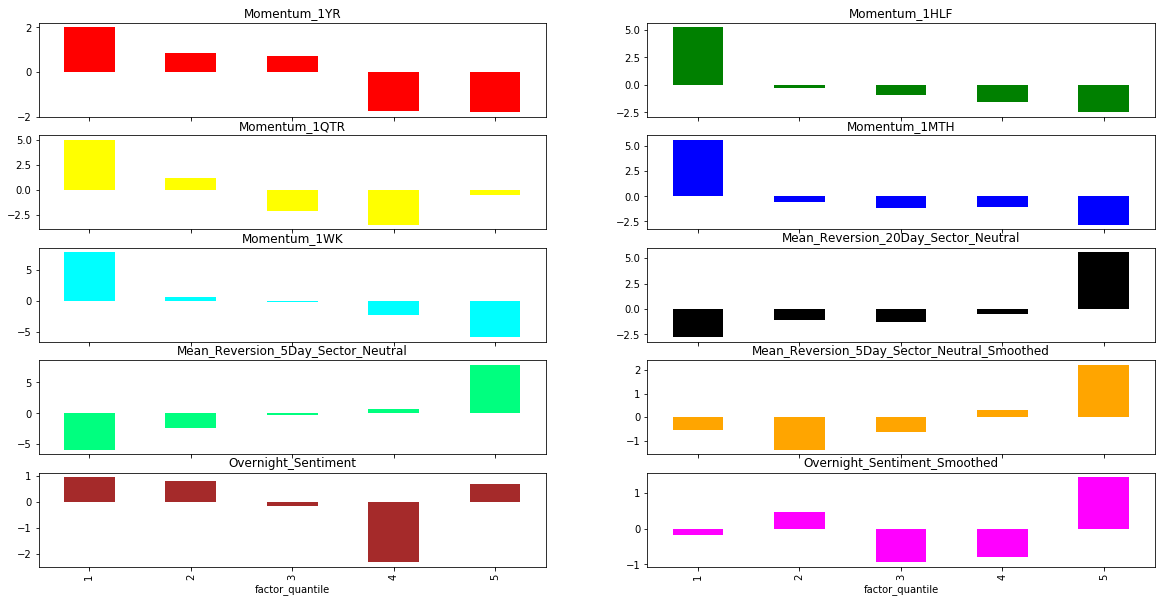

In [76]:
qr_factor_returns = qr_factor_returns.reindex(columns=columnsOrder)

plt.figure(figsize=(20, 9))
fig, axes = plt.subplots(5,2,sharex=True,figsize=(20,10))
ax = axes.ravel()

for i, col in enumerate(qr_factor_returns.columns):
  (10000*qr_factor_returns[col]).plot(ax=ax[i], kind='bar', color=colors[i], subplots=True)

In [33]:
best_quantile = {}

#Filter the best quantiles by factors that contain target stocks for trading
for factor, factor_data in clean_factor_data.items():
    #get time & ticker by best quantile    
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Mean_Reversion_20Day_Sector_Neutral':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Overnight_Sentiment':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Overnight_Sentiment_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1HLF':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1MTH':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1QTR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1WK':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1YR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    

In [34]:
len(best_quantile['Mean_Reversion_5Day_Sector_Neutral']),len(best_quantile['Momentum_1MTH']),len(best_quantile['Momentum_1YR']),len(best_quantile['Overnight_Sentiment_Smoothed'])

(131137, 130300, 122950, 139199)

In [69]:
ls_factor_returns_quantile = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Mean_Reversion_20Day_Sector_Neutral':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1HLF':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1MTH':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1QTR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1WK':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1YR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]    

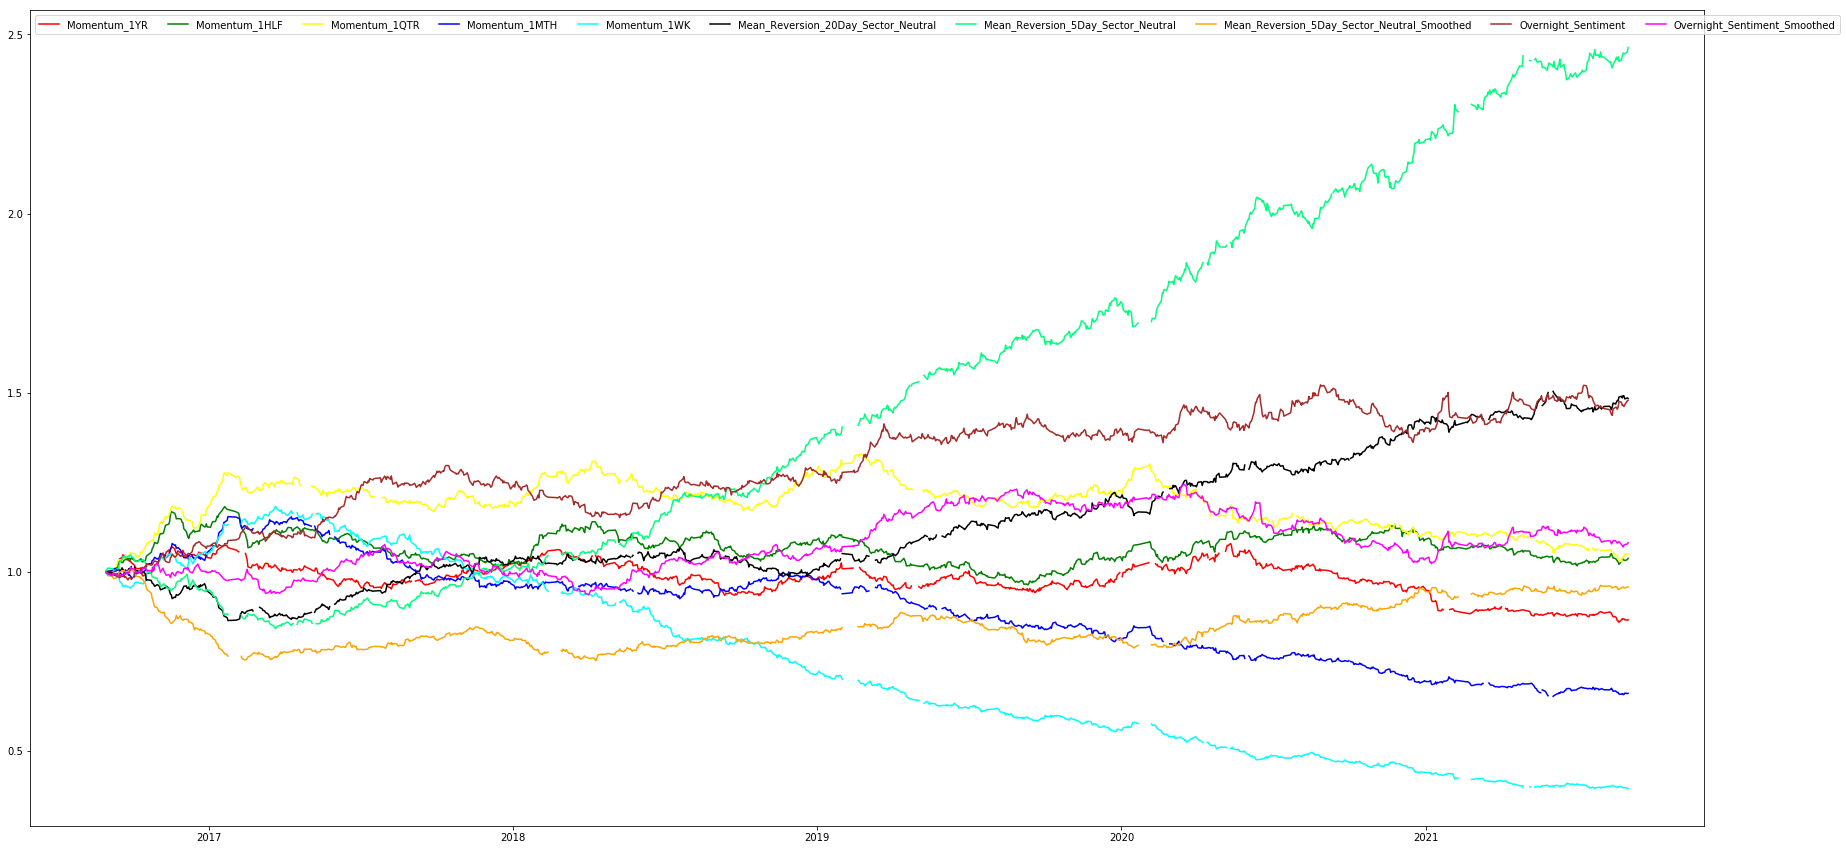

In [70]:
ls_factor_returns_quantile = ls_factor_returns_quantile.reindex(columns=columnsOrder)

plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns_quantile.columns):
  plt.plot((1+ls_factor_returns_quantile[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns_quantile.columns,loc="upper left",ncol=len(ls_factor_returns_quantile.columns))
plt.show()

In [ ]:
qr_factor_returns

Mean_Reversion_5Day_Sector_Neutral  \
factor_quantile                                       
1                                       -0.00040157   
2                                       -0.00026271   
3                                        0.00000195   
4                                       -0.00004529   
5                                        0.00070658   

                 Mean_Reversion_5Day_Sector_Neutral_Smoothed  Momentum_1HLF  \
factor_quantile                                                               
1                                                 0.00015297     0.00056935   
2                                                -0.00023473    -0.00009000   
3                                                -0.00006497    -0.00017477   
4                                                -0.00011686    -0.00019621   
5                                                 0.00026187    -0.00011178   

                 Momentum_1MNT  Momentum_1QTR  Momentum_1WK  Momentum_1YR  \
factor_quantile                                                             
1                   0.00045452     0.00073217    0.00070903    0.00024328   
2                  -0.00023573    -0.00015927   -0.00006038   -0.00001059   
3                  -0.00021815    -0.00043225    0.00001072   -0.00002635   
4                  -0.00010714    -0.00028259   -0.00025963   -0.00019239   
5                   0.00010212     0.00013579   -0.00040302   -0.00001448   

                 Overnight_Sentiment  Overnight_Sentiment_Smoothed  
factor_quantile                                                     
1                         0.00017941                    0.00019196  
2                        -0.00010564                   -0.00002600  
3                        -0.00018665                   -0.00040959  
4                        -0.00008707                   -0.00007698  
5                         0.00019858                    0.00031858

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**. 
The more stable the factor exposure, the better from transaction cost perspective. FRA close to 1 is correlate to the self well and does not require to trade a lot.
[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

In [72]:
ls_FRA = pd.DataFrame()

#Computes autocorrelation of mean factor ranks in specified time spans.
for factor, factor_data in clean_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

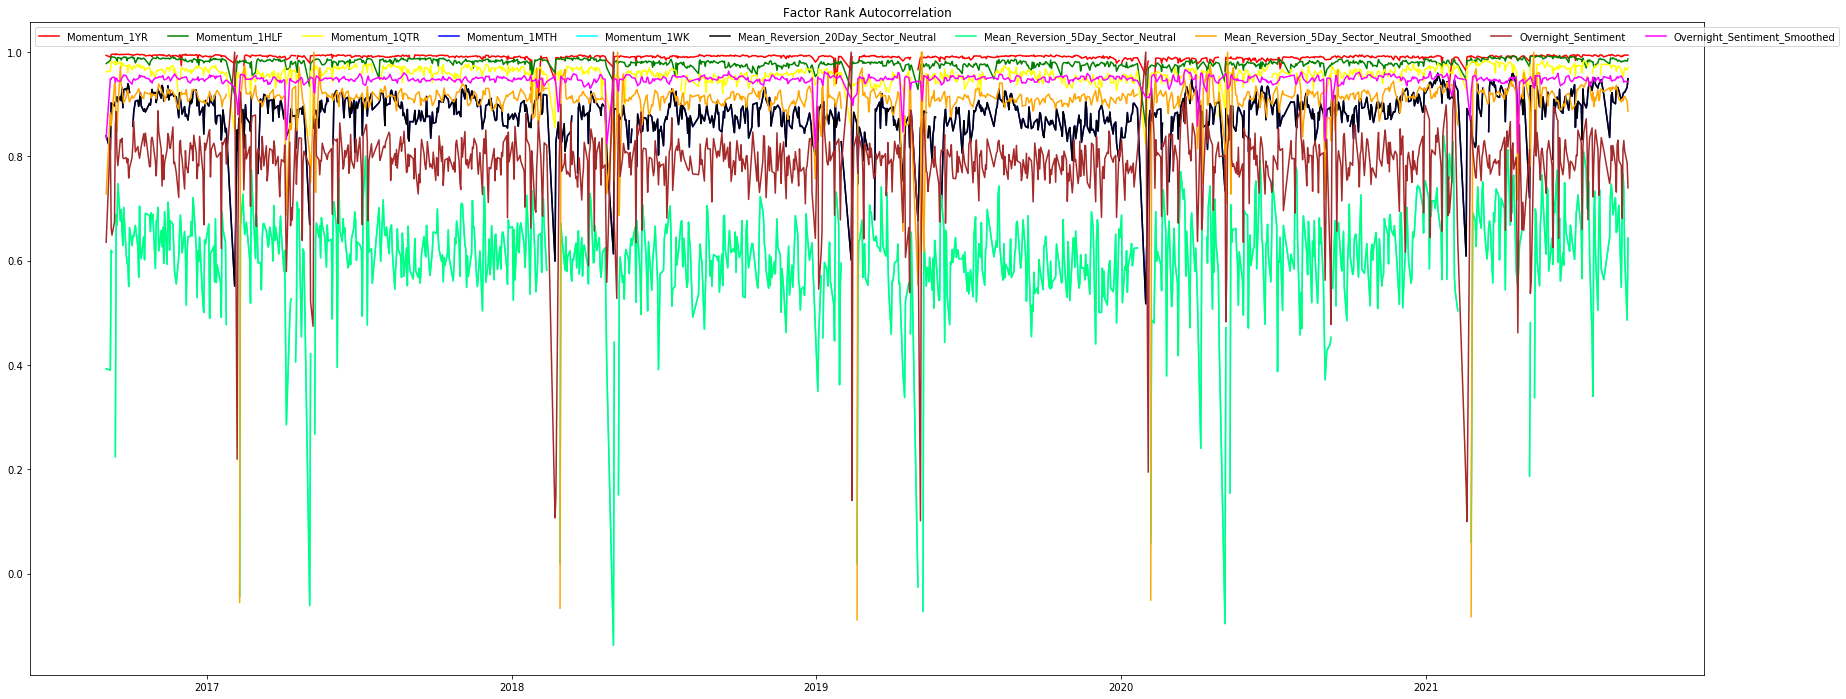

In [74]:
ls_FRA = ls_FRA.reindex(columns=columnsOrder)

plt.figure(figsize=(30, 12))
for i, col in enumerate(ls_FRA.columns):
  plt.plot(ls_FRA[col],color=colors[i])
plt.title("Factor Rank Autocorrelation")
plt.legend(ls_FRA.columns,loc="upper left",ncol=len(ls_FRA.columns))
plt.show()

This is important to have a realistic signal that is stable enough to be profitable

#### Sharpe Ratio of the Alphas

Generally, a Sharpe Ratio of near 1.0 or higher (around 1.5 to 2.0) is an acceptable single alpha for this universe.

In [52]:
daily_annualization_factor = np.sqrt(252)

amf.sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_20Day_Sector_Neutral            1.44
Overnight_Sentiment_Smoothed                   0.20
Momentum_1HLF                                 -1.61
Momentum_1YR                                  -1.02
Momentum_1WK                                  -2.77
Momentum_1MTH                                 -1.44
Momentum_1QTR                                 -1.48
Mean_Reversion_5Day_Sector_Neutral_Smoothed    0.35
Overnight_Sentiment                           -0.47
Mean_Reversion_5Day_Sector_Neutral             2.77
dtype: float64

In [48]:
amf.sharpe_ratio(ls_factor_returns_quantile, daily_annualization_factor).round(2)

Mean_Reversion_20Day_Sector_Neutral            1.15
Overnight_Sentiment_Smoothed                   0.31
Momentum_1HLF                                  0.15
Momentum_1YR                                  -0.22
Momentum_1WK                                  -2.60
Momentum_1MTH                                 -1.12
Momentum_1QTR                                  0.15
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.14
Overnight_Sentiment                            1.14
Mean_Reversion_5Day_Sector_Neutral             2.58
dtype: float64

In [49]:
all_factors.columns

Index(['Mean_Reversion_20Day_Sector_Neutral',
       'Mean_Reversion_5Day_Sector_Neutral',
       'Mean_Reversion_5Day_Sector_Neutral_Smoothed', 'Momentum_1HLF',
       'Momentum_1MTH', 'Momentum_1QTR', 'Momentum_1WK', 'Momentum_1YR',
       'Overnight_Sentiment', 'Overnight_Sentiment_Smoothed'],
      dtype='object')

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. Alphas selected based on sharpe ratio then simply averaged the scores from each alpha.

In [ ]:
selected_factors = all_factors.columns[[0,1]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

#reduce 9 cols by averaging them to 1, keep rows
all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1) 
alphas = all_factors[['alpha_vector']]


Alpha vector showing the stocks position buy or sell on each trading day. For intuitional purpose, average alpha factors on the last day to demonstrate the portfolio optimisation described in the next section.

In [17]:
#alpha vector (500 rows/stocks) for 1 day in 2021 only
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]] 
alpha_vector.tail()

Selected Factors: Mean_Reversion_20Day_Sector_Neutral, Mean_Reversion_5Day_Sector_Neutral


alpha_vector
                               
Equity(616 [WSB])      0.390925
Equity(617 [X26])      0.465115
Equity(618 [YBM])      1.301180
Equity(619 [YEG])      0.482236
Equity(620 [YTC])      1.677837

### 3.3. Multi-factor model: Optimal Portfolio Constrained by Risk Model

We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model   
by optimizing the weights under risks constrain.

### Three weight schemes:

<p>- alphas exposes under risk model  <br>
optimal_weights1 = cvx.Maximize(alpha_vector.values.T * weights)</p>


<p>- alphas exposes under risk model with regularization weights  <br>
optimal_weights1 = cvx.Maximize((alpha_vector.values.T*weights)-self.lambda_reg*cvx.pnorm(weights,2))</p>


<p>- alphas exposes under risk model with target weights  <br>
optimal_weights2 = cvx.Minimize(-(alpha_vector.values.T*weights)+cvx.pnorm(weights-target_weights,2))</p>

How to deal with these weights:  
    1.find the corresponding stocks related to PC  
    2.apply weight scheme to each stock  
    3.compute anual returns & compare to index??  

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
#find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights = mff.OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], 
                                         risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

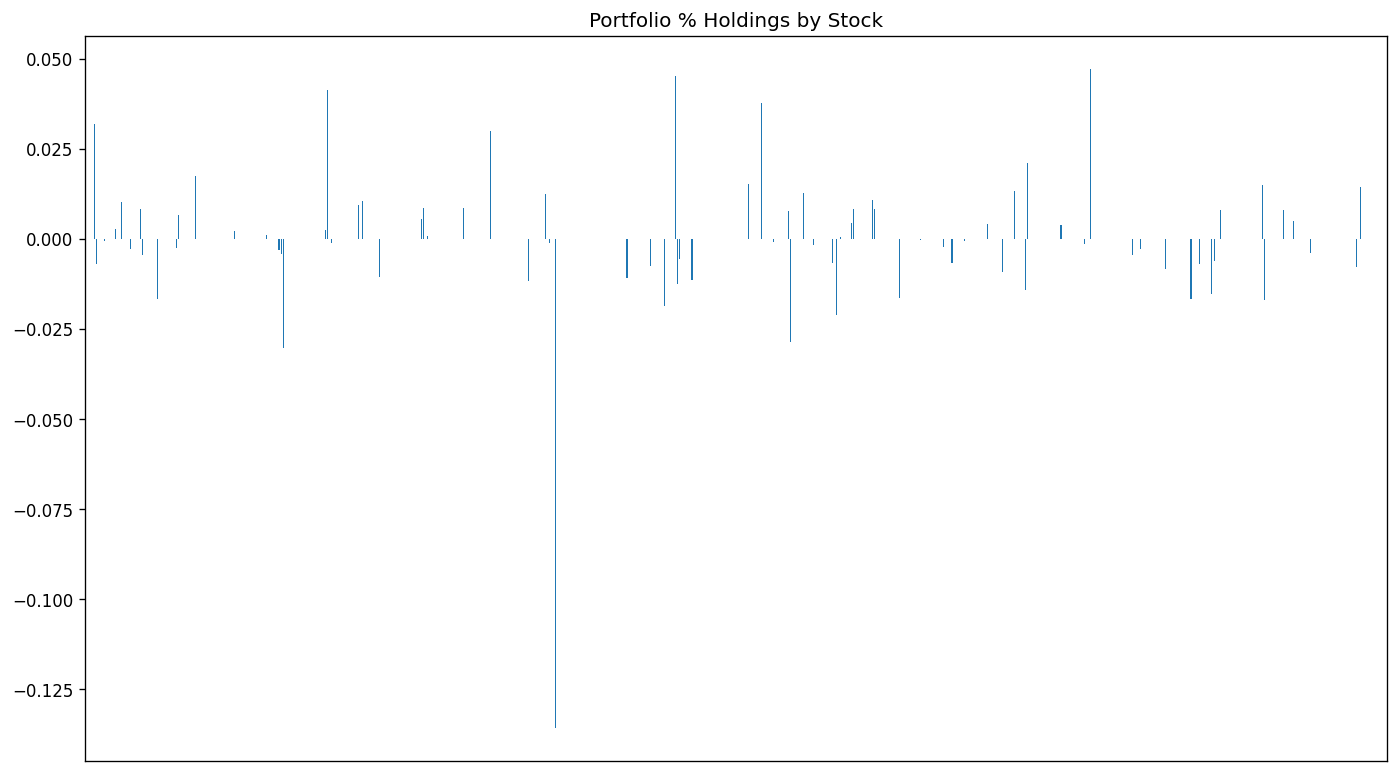

In [28]:
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

With this weight scheme, the portfolio is constructed with only a few stocks, but the more diversity in stocks of the basket, the better portfolio performance.

In [33]:
factor_betas_weight = mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights)
factor_betas_weight

0
0  -0.000835
1  -0.000807
2   0.000039
3   0.001567
4   0.001293
5   0.001891
6  -0.000424
7  -0.001862
8   0.000261
9  -0.000831
10  0.001606
11 -0.000070
12  0.001078
13 -0.001974
14 -0.002070
15 -0.004455
16 -0.003216
17  0.001292
18 -0.001639
19 -0.000720

<AxesSubplot:title={'center':'Portfolio Net Factor Exposures'}>

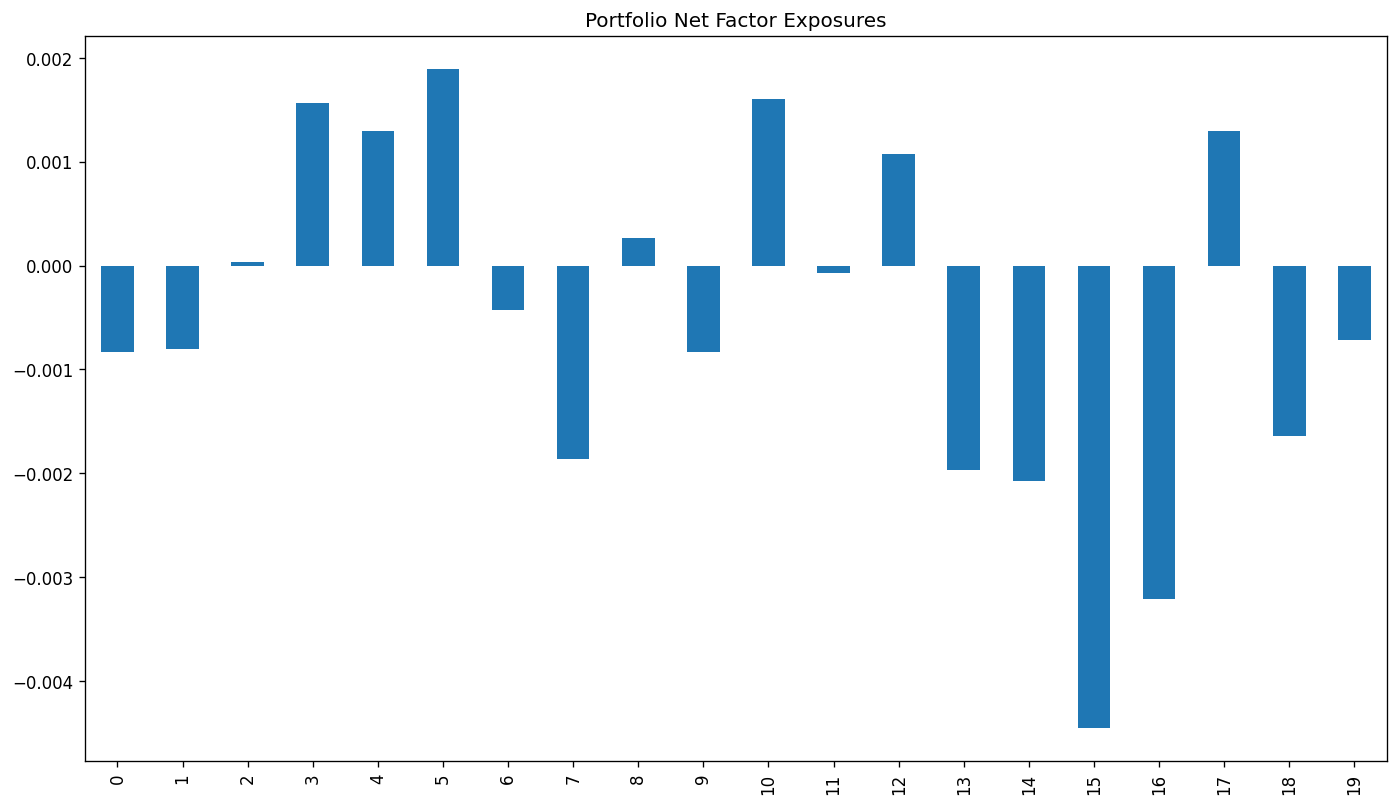

In [34]:
factor_betas_weight.plot.bar(title='Portfolio Net Factor Exposures',legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

### View Data

In [ ]:
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_1 = mff.OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, 
                  risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])


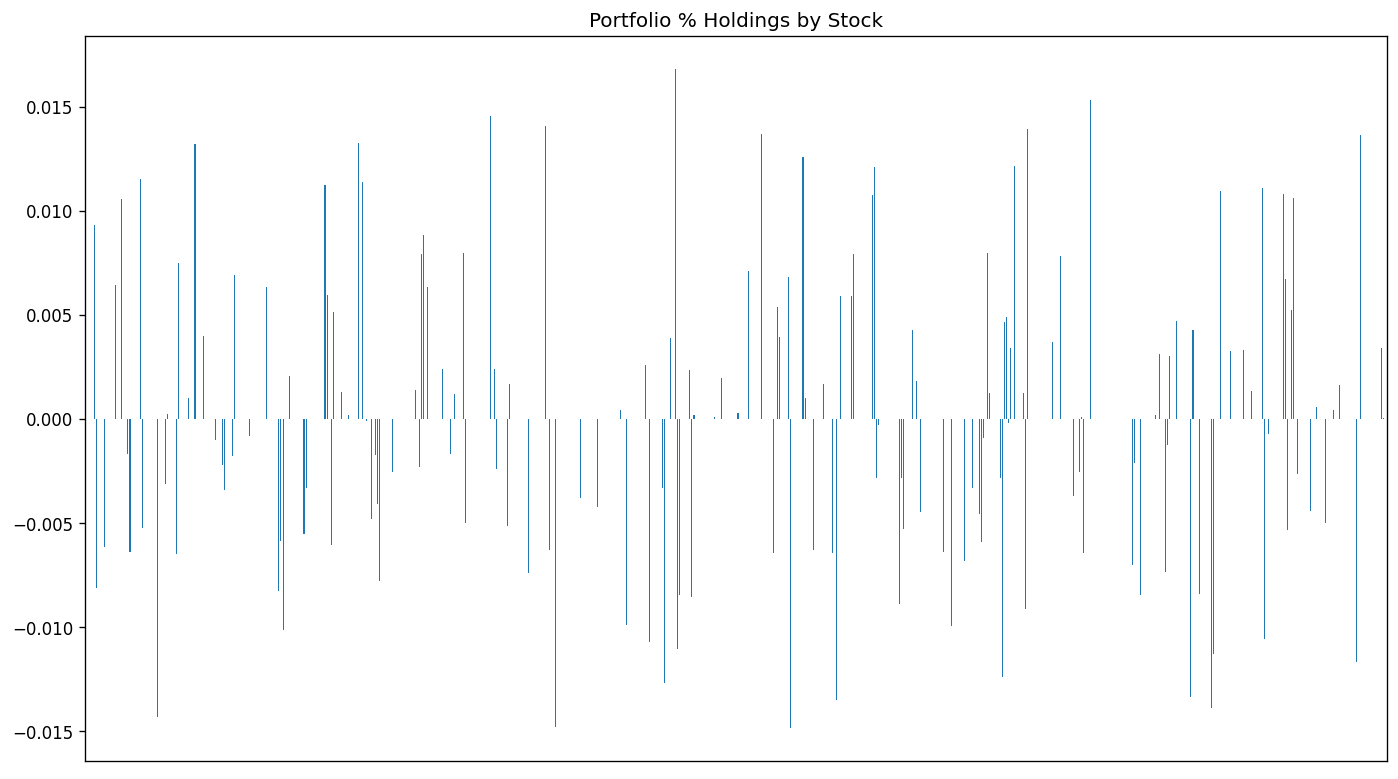

In [37]:
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

<AxesSubplot:title={'center':'Portfolio Net Factor Exposures'}>

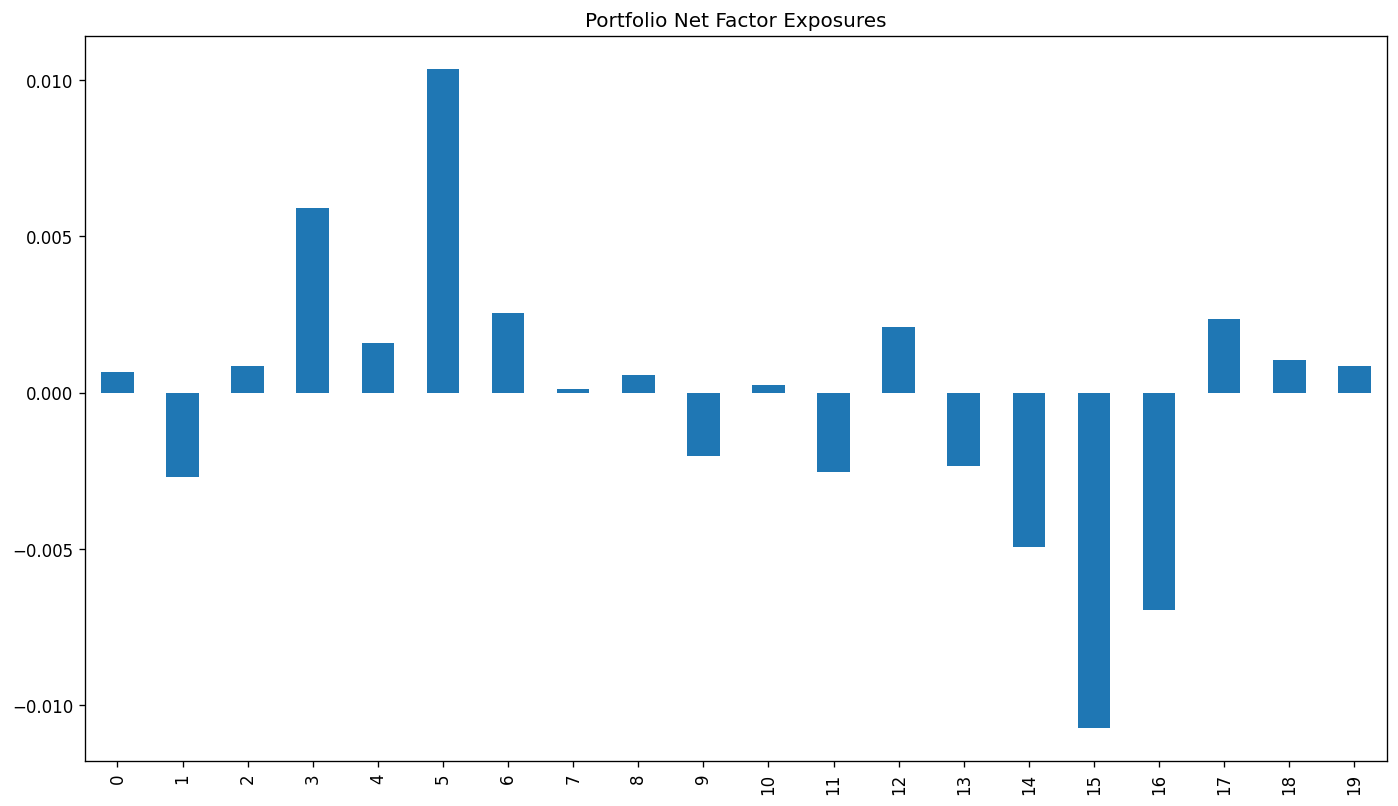

In [39]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

### View Data

In [ ]:
#__init__(self,lambda_reg=0.5,risk_cap=0.05,factor_max=10.0,factor_min=-10.0,weights_max=0.55,weights_min=-0.55)
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_2 = mff.OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector,risk_model['factor_betas'],risk_model['factor_cov_matrix'], 
                            risk_model['idiosyncratic_var_vector'])

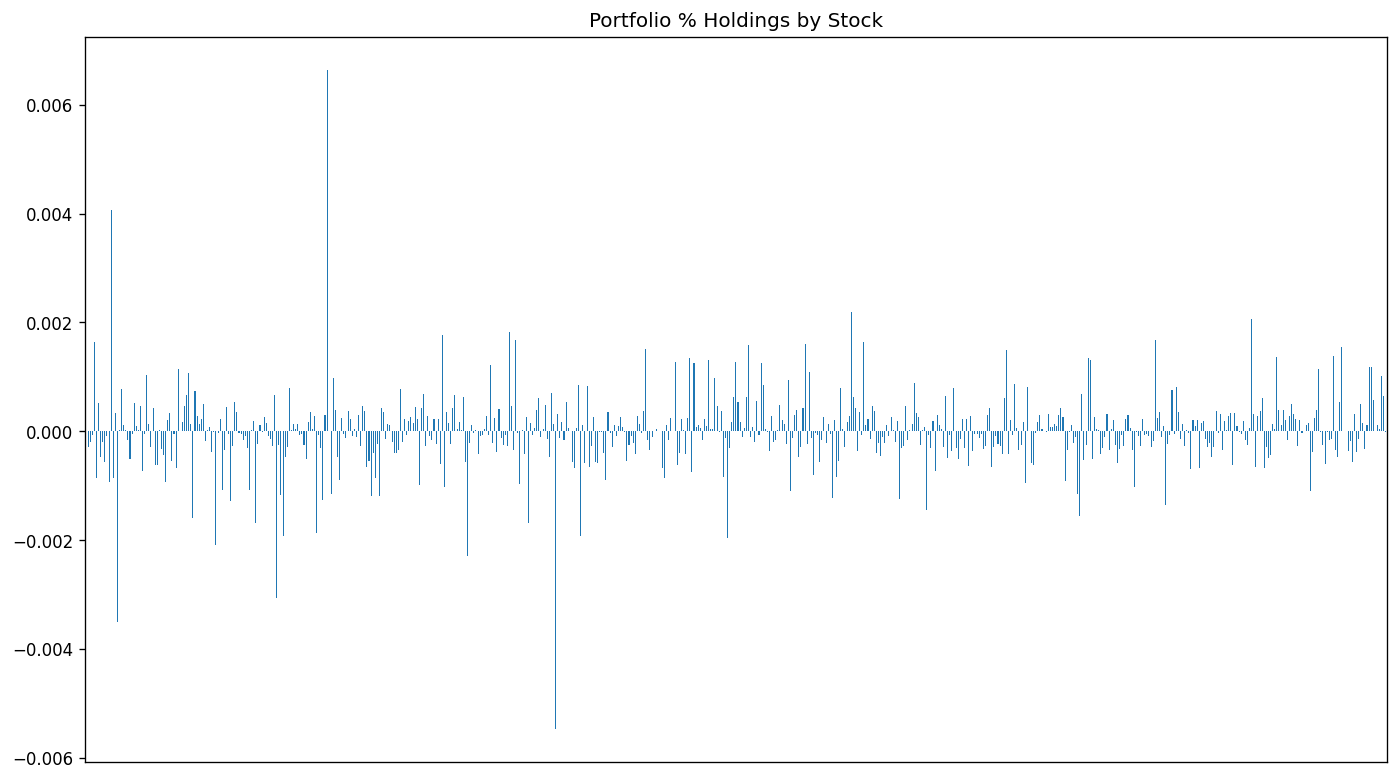

In [41]:
optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [42]:
optimal_weights_2.index = risk_model['factor_betas'].index

<AxesSubplot:title={'center':'Portfolio Net Factor Exposures'}>

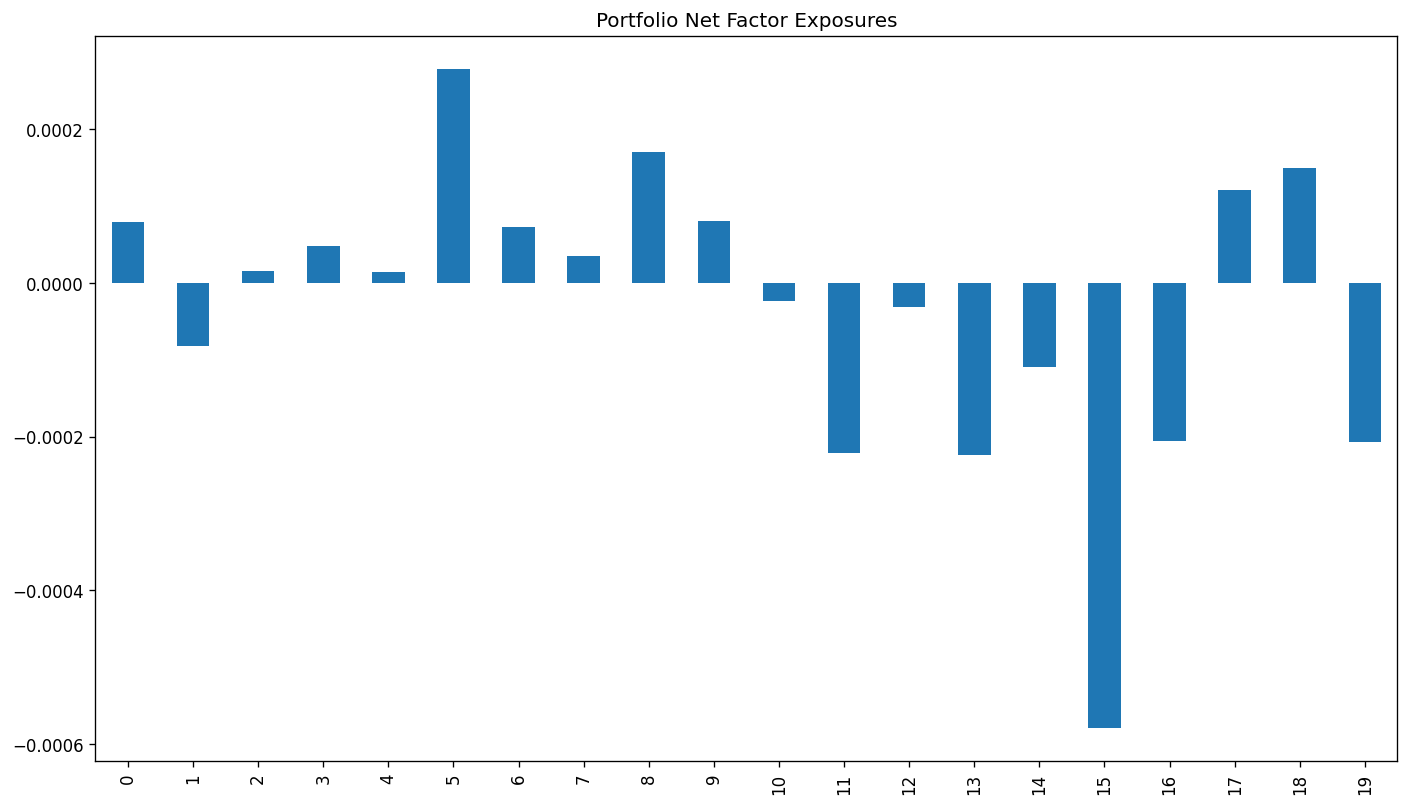

In [43]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

### Transfer Coefficient
The optimisation with certain constraints makes the actual portfolio returns deviate from alpha signals. Checking the correlation coefficient between alpha vector and the portfolio weight could assess how efficency between schemes. The closer to 1 the better weight scheme

In [54]:
alphas = pd.read_csv('./data/alphas.csv', index_col=[0,1])
alpha_vector = alphas.loc[alphas.index.get_level_values(0)[-1]]
alpha_vector.tail()

alpha_vector
asset                          
Equity(616 [WSB])      0.390925
Equity(617 [X26])      0.465115
Equity(618 [YBM])      1.301180
Equity(619 [YEG])      0.482236
Equity(620 [YTC])      1.677837

In [90]:
optimal_weights.tail()

0
Equity(616 [WSB])  4.059902e-13
Equity(617 [X26])  5.483900e-13
Equity(618 [YBM])  4.084503e-12
Equity(619 [YEG])  1.312081e-12
Equity(620 [YTC])  1.325310e-13

<h2>4. Conclusions</h2>

- This is just a very simple by leaving complex parts aside but effective way to quickly validate the alpha idea before the [full-backtesting]( https://medium.com/swlh/how-to-build-quant-algorithmic-trading-model-in-python-12abab49abe3)  
- Mean reversion factors outperform for the universe of 621 stocks working for 1 day looking forward  
- The 3rd weights scheme reflects the best real trading condition


## Recommendations
- Stock universe (candidate selection) could be filtered by size (volume), value (price) or other fundamental factors such as: dividend, P/E… or even following ETF indexes: vnindex, vn30index…
- Recommended further steps: create more portfolios, back-testing under real trading condition in order to fully assess how effective, persistent & resilient the factor models are
